# Aligning HST images to an absolute reference catalog
***

<div class="alert-danger">Note: The notebook in this repository 'Initializtion.ipynb' goes over many of the basic concepts such as the setup of the environment/package installation and should be read first if you are new to HST images, 'DrizzlePac' or 'Astroquery'.</div>

<div class="alert-warning">Note: This notebook is based on WFC3 ISR 2017-19: <a href="http://www.stsci.edu/hst/wfc3/documents/ISRs/WFC3-2017-19.pdf">Aligning HST Images to Gaia: a Faster Mosaicking Workflow</a> and contains a subset of the information/code found in <a href="https://github.com/spacetelescope/gaia_alignment">the repository here</a>.  For more information, see the notebook in that repository titled 'Gaia_alignment.ipynb'.</div>

## Introduction

The alignment of HST exposures is a critical step in image stacking/combination performed by software such as `AstroDrizzle`.  Generally, a relative alignment is performed that aligns one image (or multiple images) to another image which is designated as the reference image.  This makes it so the images are aligned to each other, but the pointing error of the observatory can still cause the images to have incorrect absolute astrometry.

When absolute astrometry is desired, the images can be aligned to an external catalog that is known to be on an absolute frame.  In this example, we will provide a workflow to query catalogs such as SDSS and Gaia via the astroquery package, and then align the images to that catalog via TweakReg.

For more information about TweakReg, see the other notebooks in this repository or the __[TweakReg Documentation](https://drizzlepac.readthedocs.io/en/deployment/tweakreg.html)__.

For more information on Astroquery, see the other notebooks in this repository or the __[Astroquery Documentation](https://astroquery.readthedocs.io/en/latest/)__.

In [1]:
import astropy.units as u
import glob
import numpy as np
import matplotlib.pyplot as plt
import os

from astropy.io import fits
from astropy.table import Table
from astropy.units import Quantity
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
from astroquery.mast import Observations
from astroquery.sdss import SDSS

from ccdproc import ImageFileCollection
from IPython.display import Image

from drizzlepac import tweakreg
from drizzlepac import astrodrizzle

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


/opt/conda/envs/notebooks_env/lib/python3.6/site-packages/astroquery/sdss/__init__.py:29: UserWarning: Experimental: SDSS has not yet been refactored to have its API match the rest of astroquery (but it's nearly there).
  warnings.warn("Experimental: SDSS has not yet been refactored to have its API "


The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg           updatenpol


# 1. Download the Data
For this example, we will use WFC3/UVIS images of NGC 6791 from Visit 01 of proposal 12692.

In [2]:
# Get the observation records
obsTable = Observations.query_criteria(obs_id='ibwb01*', proposal_id=12692, obstype='all', filters='F606W')

# Get the listing of data products
products = Observations.get_product_list(obsTable)

# Filter the products for exposures
filtered_products = Observations.filter_products(products, productSubGroupDescription='FLC')

# Show the table
filtered_products

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid
str10,str3,str5,str9,str64,str1,str40,str9,str28,str8,str1,str6,str18,str5,str23,int64,str10
2002940424,HST,image,ibwb01xqq,DADS FLC file - CTE-corrected calibrated exposure ACS/WFC3,S,mast:HST/product/ibwb01xqq_flc.fits,AUXILIARY,Minimum Recommended Products,FLC,--,CALWF3,3.5.0(Oct-09-2018),12692,ibwb01xqq_flc.fits,168203520,2002940424
2002940425,HST,image,ibwb01xrq,DADS FLC file - CTE-corrected calibrated exposure ACS/WFC3,S,mast:HST/product/ibwb01xrq_flc.fits,AUXILIARY,Minimum Recommended Products,FLC,--,CALWF3,3.5.0(Oct-09-2018),12692,ibwb01xrq_flc.fits,168203520,2002940425
2002940428,HST,image,ibwb01xxq,DADS FLC file - CTE-corrected calibrated exposure ACS/WFC3,S,mast:HST/product/ibwb01xxq_flc.fits,AUXILIARY,Minimum Recommended Products,FLC,--,CALWF3,3.5.0(Oct-09-2018),12692,ibwb01xxq_flc.fits,168203520,2002940428


In [3]:
# Download all the images above
Observations.download_products(filtered_products, mrp_only=False)

 [Done]


 [Done]


 [Done]


Local Path,Status,Message,URL
str47,str8,object,object
./mastDownload/HST/ibwb01xqq/ibwb01xqq_flc.fits,COMPLETE,None,None
./mastDownload/HST/ibwb01xrq/ibwb01xrq_flc.fits,COMPLETE,None,None
./mastDownload/HST/ibwb01xxq/ibwb01xxq_flc.fits,COMPLETE,None,None


In [4]:
# For convenience, move the products into the current directory.
for flc in glob.glob('./mastDownload/HST/*/*flc.fits'):
    flc_name = os.path.split(flc)[-1]
    os.rename(flc, flc_name)

### Inspect the image header

The cell below shows how to query information from the image header using `ImageFileCollection` in `ccdproc`. 
We see that the 1st exposure is 30 seconds and the 2nd and 3rd exposures are 360 seconds. The 3rd exposure is dithered by ~82" in the Y-direction which is approximately the width of one UVIS chip. 

In [5]:
collec = ImageFileCollection('./', glob_include="*flc.fits", ext=0,
                             keywords=["targname", "ra_targ", "dec_targ", "filter", "exptime", "postarg1", "postarg2"])

table = collec.summary
table['exptime'].format = '7.1f'
table['ra_targ'].format = '7.7f'
table['dec_targ'].format = '7.7f'
table['postarg1'].format = '7.2f'
table['postarg2'].format = '7.2f'
table

file,targname,ra_targ,dec_targ,filter,exptime,postarg1,postarg2
str18,str8,float64,float64,str5,float64,float64,float64
ibwb01xqq_flc.fits,NGC-6791,290.2247917,37.8026667,F606W,30.0,0.00,0.00
ibwb01xrq_flc.fits,NGC-6791,290.2247917,37.8026667,F606W,360.0,0.00,0.00
ibwb01xxq_flc.fits,NGC-6791,290.2247917,37.8026667,F606W,360.0,0.00,81.60


# 2. Querying catalogs

Now that we have the images, we will download the reference catalogs from both SDSS and Gaia using `astroquery`.

### 2a. Identify Coordinates
We will first create a SkyCoord Object to point astroquery to where we are looking on the sky.  Since our example uses data from NGC 6791, we will use the `ra_targ` and `dec_targ` keywords from the first image to get the coordinates of the object.

In [6]:
RA = table['ra_targ'][0]
Dec = table['dec_targ'][0]

### 2b. SDSS Query
We now give those values to an astropy `SkyCoord` object, which we will pass to the SDSS.  Additionally, we use an astropy `Quantity` object to create a radius for the SDSS query.  We set the radius to 6 arcminutes to comfortably cover the area of our images. For reference UVIS detector field of view is ~2.7'x2.7' and a y-dither of 82" covers a total area on the sky of ~2.7'x4.1'.

In [7]:
coord = SkyCoord(ra=RA, dec=Dec, unit=(u.deg, u.deg))
radius = Quantity(6., u.arcmin)

Then we only need to perform the query via the `SDSS.query_region` method of `astroquery.sdss`. The `spectro=False` keyword argument means we want to exclude spectroscopic objects, as we are looking for objects to match with an image.  

In the fields parameter, we specify a list of fields we want returned by the query.  In this case we only need the position, and maybe a magnitude 'g' if we want to cut very dim and/or bright objects out of the catalog, as those are likely measured poorly. Details on selecting objects by magnitude may be found in the original ['Gaia_alignment' notebook](https://github.com/spacetelescope/gaia_alignment).  Many other fields are available in the SDSS query and are [documented here](http://cas.sdss.org/dr7/en/help/browser/description.asp?n=PhotoObj&t=V).

In [8]:
sdss_query = SDSS.query_region(coord, radius=radius, spectro=False, fields=['ra', 'dec', 'g'])
sdss_query

ra,dec,g
float64,float64,float64
290.125105064604,37.821624666375,18.45112
290.125122492815,37.8216020349638,18.31671
290.125146602092,37.9010193344944,19.85297
290.125152491123,37.9010182570309,19.69171
290.125176884507,37.8043377949469,25.04455
290.125194824392,37.8043830142165,24.48421
290.125223559028,37.8727607956207,20.85623
290.125230717288,37.7191912315093,24.98921
290.125241380255,37.8386579918808,15.33426


We then just need to save the catalog to use with TweakReg.  Since the returned value of the query is an `astropy.Table`, saving the file is very straightforward:

In [9]:
sdss_query.write('sdss.cat', format='ascii.commented_header')

### 2c. Gaia Query
Similarly to SDSS, we can query Gaia catalogs for our target via `astroquery.gaia`.  We can use the same `coord` and  `radius` from the SDSS query.

In [10]:
gaia_query = Gaia.query_object_async(coordinate=coord, radius=radius)
gaia_query

  warn_or_raise(W35, W35, ('value'), self._config, self._pos)



  warn_or_raise(W35, W35, ('value'), self._config, self._pos)



  warn_or_raise(W35, W35, ('value'), self._config, self._pos)



  warn_or_raise(W35, W35, ('value'), self._config, self._pos)



  warn_or_raise(W35, W35, ('value'), self._config, self._pos)



  warn_or_raise(W27, W27, (), config, pos)



  vo_warn(W06, (ucd, str(e)), config, pos)



  self._config, self._pos)



  self._config, self._pos)



  self._config, self._pos)



  self._config, self._pos)



  self._config, self._pos)



  self._config, self._pos)



  vo_warn(W06, (ucd, str(e)), config, pos)



  self._config, self._pos)



  vo_warn(W06, (ucd, str(e)), config, pos)



  self._config, self._pos)



  self._config, self._pos)



  vo_warn(W06, (ucd, str(e)), config, pos)



  self._config, self._pos)



  vo_warn(W06, (ucd, str(e)), config, pos)



  vo_warn(W06, (ucd, str(e)), config, pos)



  vo_warn(W06, (ucd, str(e)), config, pos)



  vo_warn(W06, (ucd, str(e)), config, pos)



  vo_warn(W06, (ucd, str(e)), config, pos)



  vo_warn(W06, (ucd, str(e)), config, pos)



Query finished.


dist,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max,frame_rotator_object_type,matched_observations,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url
,,,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / mas2,1 / um,1 / um,,,,mas,,,,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,,mag,mag,mag,km / s,km / s,,K,log(cm.s**-2),dex,,deg,deg,deg,deg,,K,K,K,mag,mag,mag,mag,mag,mag,,Rsun,Rsun,Rsun,Lsun,Lsun,Lsun,,
float64,int64,object,int64,int64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,float32,float32,float64,float64,int16,bool,float32,float64,float64,float32,int16,int16,float32,int32,int16,bool,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,float32,int16,float32,float32,float32,float64,float64,int32,float32,float32,float32,object,float64,float64,float64,float64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,object,object
0.0007457750280585006,1635721458409799680,Gaia DR2 2051293319932402944,2051293319932402944,1675162907,2015.5,290.2248612117769,0.17025317759995298,37.801928644334666,0.23706526958649082,0.9169012687299769,0.2320288738061574,3.9516687,-0.7436331528144198,0.3812622579469638,6.010353940292694,0.5025560536657159,0.07765845,0.19423231,-0.002706211,-0.20296262,0.26506588,-0.22303766,-0.1096294,-0.17967537,-0.07058169,-0.061190978,215,0,214,1,1.9095645,249.77103,0.6411118327127229,1.2557711706373367,31,False,0.26720327,1.39814863054866,0.05706386095029324,0.05975954,25,15,0.44619527,0,27,False,230,476.3769381965007,1.1245576505069257,423.61273,18.993488,18,136.8471182536094,8.327590887105266,16.432978,20.0108,18,577.3836822334904,8.364935664317445,69.024284,17.85826,1.4992976,0,2.1525402,1.0173111,1.1352291,--,--,0,--,--,--,NOT_AVAILABLE,69.98761815072085,10.91419930893231,302.0419654146322,59.011908313993786,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,http://geadata.esac.esa.int/data-server/datalink/links?ID=2051293319932402944,--
0.0012110279047063879,1635721458409799680,Gaia DR2 2051293324218263808,2051293324218263808,1595923736,2015.5,290.223279633381,1.5690004116043692,37.80283985940256,1.6547840094163826,-1.320572176475729,1.8191390036660162,-

This query has returned very large number of columns. We want to pare down the catalog to make it easier to use with `TweakReg`.  
We can select only the useful columns via:

In [11]:
reduced_query = gaia_query['ra', 'dec', 'phot_g_mean_mag']
reduced_query

ra,dec,phot_g_mean_mag
deg,deg,mag
float64,float64,float32
290.2248612117769,37.801928644334666,18.993488
290.223279633381,37.80283985940256,20.828722
290.2226200636918,37.80270788854854,16.649422
290.2248310561946,37.80058642553806,17.595186
290.2225603235312,37.8039787667679,18.654873
290.22681932060266,37.80112775249116,20.771065
290.2275250867832,37.80347302560439,19.938679
290.2242323214596,37.80039574182613,20.654758


Then we write this catalog to an ascii file for use with `TweakReg`.

In [12]:
reduced_query.write('gaia.cat', format='ascii.commented_header')

## 3. Running TweakReg
With the catalogs downloaded and the headers populated, we simply need to run TweakReg with each catalog passed into the `refcat` parameter. The steps below compare the astrometric residuals obtained from aligning to each `refcat`. In each test case, we set `updatehdr` to False until we are satisfied with the alignment by inspecting both the shift file and the astrometric residual plots.

### 3a. SDSS Alignment

INFO:drizzlepac.util:Setting up logfile :  tweakreg.log


Setting up logfile :  tweakreg.log


INFO:drizzlepac.tweakreg:TweakReg Version 1.4.7(18-April-2018) started at: 19:21:11.841 (21/03/2019) 


TweakReg Version 1.4.7(18-April-2018) started at: 19:21:11.841 (21/03/2019) 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.util:Version Information


Version Information


INFO:drizzlepac.util:--------------------


--------------------


INFO:drizzlepac.util:Python Version [GCC 7.3.0]


Python Version [GCC 7.3.0]


INFO:drizzlepac.util:3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 


3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 


INFO:drizzlepac.util:numpy Version -> 1.15.4 


numpy Version -> 1.15.4 


INFO:drizzlepac.util:astropy Version -> 3.1.2 


astropy Version -> 3.1.2 


INFO:drizzlepac.util:stwcs Version -> 1.4.2 


stwcs Version -> 1.4.2 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS common to all Processing Steps:


INFO:drizzlepac.tweakreg:	clean :	False


INFO:drizzlepac.tweakreg:	enforce_user_order :	True


INFO:drizzlepac.tweakreg:	exclusions :	


INFO:drizzlepac.tweakreg:	expand_refcat :	False


INFO:drizzlepac.tweakreg:	input :	*flc.fits


INFO:drizzlepac.tweakreg:	interactive :	False


INFO:drizzlepac.tweakreg:	refimage :	


INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log


INFO:drizzlepac.tweakreg:	updatewcs :	False


INFO:drizzlepac.tweakreg:	verbose :	False


INFO:drizzlepac.tweakreg:	writecat :	True


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Finding shifts for: 


Finding shifts for: 


INFO:drizzlepac.tweakreg:    ibwb01xrq_flc.fits


    ibwb01xrq_flc.fits


INFO:drizzlepac.tweakreg:    ibwb01xxq_flc.fits


    ibwb01xxq_flc.fits


INFO:drizzlepac.tweakreg:    ibwb01xqq_flc.fits


    ibwb01xqq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for each input image:


INFO:drizzlepac.tweakreg:	clean :	False


INFO:drizzlepac.tweakreg:	computesig :	True


INFO:drizzlepac.tweakreg:	conv_width :	3.5


INFO:drizzlepac.tweakreg:	dqbits :	


INFO:drizzlepac.tweakreg:	enforce_user_order :	True


INFO:drizzlepac.tweakreg:	expand_refcat :	False


INFO:drizzlepac.tweakreg:	fluxmax :	None


INFO:drizzlepac.tweakreg:	fluxmin :	None


INFO:drizzlepac.tweakreg:	input :	*flc.fits


INFO:drizzlepac.tweakreg:	interactive :	False


INFO:drizzlepac.tweakreg:	nsigma :	1.5


INFO:drizzlepac.tweakreg:	peakmax :	None


INFO:drizzlepac.tweakreg:	peakmin :	None


INFO:drizzlepac.tweakreg:	ratio :	1.0


INFO:drizzlepac.tweakreg:	refimage :	


INFO:drizzlepac.tweakreg:	roundhi :	1.0


INFO:drizzlepac.tweakreg:	roundlo :	-1.0


INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log


INFO:drizzlepac.tweakreg:	sharphi :	1.0


INFO:drizzlepac.tweakreg:	sharplo :	0.2


INFO:drizzlepac.tweakreg:	skysigma :	0.0


INFO:drizzlepac.tweakreg:	theta :	0.0


INFO:drizzlepac.tweakreg:	threshold :	500.0


INFO:drizzlepac.tweakreg:	updatehdr :	False


INFO:drizzlepac.tweakreg:	updatewcs :	False


INFO:drizzlepac.tweakreg:	use_sharp_round :	False


INFO:drizzlepac.tweakreg:	verbose :	False


INFO:drizzlepac.tweakreg:	writecat :	True


INFO:drizzlepac.tweakreg:	xyunits :	pixels


INFO:drizzlepac.tweakreg:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.imgclasses:===  Source finding for image 'ibwb01xrq_flc.fits':


===  Source finding for image 'ibwb01xrq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibwb01xrq_flc.fits', EXT=('SCI', 1) started at: 19:21:12.007 (21/03/2019)


  #  Source finding for 'ibwb01xrq_flc.fits', EXT=('SCI', 1) started at: 19:21:12.007 (21/03/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 5.638966


INFO:drizzlepac.catalogs:###Source finding finished at: 19:21:12.764 (21/03/2019)


INFO:drizzlepac.catalogs:     Found 1363 objects.


     Found 1363 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'ibwb01xrq_flc.fits', EXT=('SCI', 2) started at: 19:21:12.838 (21/03/2019)


  #  Source finding for 'ibwb01xrq_flc.fits', EXT=('SCI', 2) started at: 19:21:12.838 (21/03/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 5.682907


INFO:drizzlepac.catalogs:###Source finding finished at: 19:21:13.655 (21/03/2019)


INFO:drizzlepac.catalogs:     Found 1313 objects.


     Found 1313 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibwb01xrq_flc.fits': 2676


===  FINAL number of objects in image 'ibwb01xrq_flc.fits': 2676


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibwb01xxq_flc.fits':


===  Source finding for image 'ibwb01xxq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibwb01xxq_flc.fits', EXT=('SCI', 1) started at: 19:21:13.996 (21/03/2019)


  #  Source finding for 'ibwb01xxq_flc.fits', EXT=('SCI', 1) started at: 19:21:13.996 (21/03/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 4.939314


INFO:drizzlepac.catalogs:###Source finding finished at: 19:21:14.769 (21/03/2019)


INFO:drizzlepac.catalogs:     Found 1836 objects.


     Found 1836 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'ibwb01xxq_flc.fits', EXT=('SCI', 2) started at: 19:21:14.845 (21/03/2019)


  #  Source finding for 'ibwb01xxq_flc.fits', EXT=('SCI', 2) started at: 19:21:14.845 (21/03/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 4.820505


INFO:drizzlepac.catalogs:###Source finding finished at: 19:21:15.559 (21/03/2019)


INFO:drizzlepac.catalogs:     Found 2008 objects.


     Found 2008 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibwb01xxq_flc.fits': 3844


===  FINAL number of objects in image 'ibwb01xxq_flc.fits': 3844


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibwb01xqq_flc.fits':


===  Source finding for image 'ibwb01xqq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibwb01xqq_flc.fits', EXT=('SCI', 1) started at: 19:21:15.803 (21/03/2019)


  #  Source finding for 'ibwb01xqq_flc.fits', EXT=('SCI', 1) started at: 19:21:15.803 (21/03/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 1.846397


INFO:drizzlepac.catalogs:###Source finding finished at: 19:21:16.596 (21/03/2019)


INFO:drizzlepac.catalogs:     Found 1364 objects.


     Found 1364 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'ibwb01xqq_flc.fits', EXT=('SCI', 2) started at: 19:21:16.670 (21/03/2019)


  #  Source finding for 'ibwb01xqq_flc.fits', EXT=('SCI', 2) started at: 19:21:16.670 (21/03/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 0.389856


INFO:drizzlepac.catalogs:###Source finding finished at: 19:21:17.440 (21/03/2019)


INFO:drizzlepac.catalogs:     Found 2137 objects.


     Found 2137 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibwb01xqq_flc.fits': 3501


===  FINAL number of objects in image 'ibwb01xqq_flc.fits': 3501


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for the reference image (not used):


INFO:drizzlepac.tweakreg:	clean :	False


INFO:drizzlepac.tweakreg:	computesig :	True


INFO:drizzlepac.tweakreg:	conv_width :	3.5


INFO:drizzlepac.tweakreg:	dqbits :	


INFO:drizzlepac.tweakreg:	enforce_user_order :	True


INFO:drizzlepac.tweakreg:	expand_refcat :	False


INFO:drizzlepac.tweakreg:	fluxmax :	None


INFO:drizzlepac.tweakreg:	fluxmin :	None


INFO:drizzlepac.tweakreg:	input :	*flc.fits


INFO:drizzlepac.tweakreg:	interactive :	False


INFO:drizzlepac.tweakreg:	nsigma :	1.5


INFO:drizzlepac.tweakreg:	peakmax :	None


INFO:drizzlepac.tweakreg:	peakmin :	None


INFO:drizzlepac.tweakreg:	ratio :	1.0


INFO:drizzlepac.tweakreg:	refimage :	


INFO:drizzlepac.tweakreg:	roundhi :	1.0


INFO:drizzlepac.tweakreg:	roundlo :	-1.0


INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log


INFO:drizzlepac.tweakreg:	sharphi :	1.0


INFO:drizzlepac.tweakreg:	sharplo :	0.2


INFO:drizzlepac.tweakreg:	skysigma :	0.0


INFO:drizzlepac.tweakreg:	theta :	0.0


INFO:drizzlepac.tweakreg:	threshold :	4.0


INFO:drizzlepac.tweakreg:	updatehdr :	False


INFO:drizzlepac.tweakreg:	updatewcs :	False


INFO:drizzlepac.tweakreg:	use_sharp_round :	False


INFO:drizzlepac.tweakreg:	verbose :	False


INFO:drizzlepac.tweakreg:	writecat :	True


INFO:drizzlepac.tweakreg:	xyunits :	pixels


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.imgclasses:Converting RA/Dec positions of reference sources from "ibwb01xrq_flc.fits" to X,Y positions in reference WCS...


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:Performing alignment in the projection plane defined by the WCS


Performing alignment in the projection plane defined by the WCS


INFO:drizzlepac.tweakreg:derived from 'ibwb01xrq_flc.fits'


derived from 'ibwb01xrq_flc.fits'


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for matching sources:


INFO:drizzlepac.tweakreg:	minobj :	15


INFO:drizzlepac.tweakreg:	residplot :	both


INFO:drizzlepac.tweakreg:	searchrad :	1.0


INFO:drizzlepac.tweakreg:	searchunits :	arcseconds


INFO:drizzlepac.tweakreg:	see2dplot :	False


INFO:drizzlepac.tweakreg:	separation :	0.5


INFO:drizzlepac.tweakreg:	tolerance :	1.0


INFO:drizzlepac.tweakreg:	use2dhist :	True


INFO:drizzlepac.tweakreg:	xoffset :	0.0


INFO:drizzlepac.tweakreg:	yoffset :	0.0


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for fitting source lists:


INFO:drizzlepac.tweakreg:	fitgeometry :	general


INFO:drizzlepac.tweakreg:	labelsize :	8


INFO:drizzlepac.tweakreg:	minobj :	15


INFO:drizzlepac.tweakreg:	nclip :	3


INFO:drizzlepac.tweakreg:	residplot :	both


INFO:drizzlepac.tweakreg:	sigma :	3.0


INFO:drizzlepac.tweakreg:	ylimit :	1.5


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for creating a shiftfile:


INFO:drizzlepac.tweakreg:	outshifts :	SDSS_shifts.txt


INFO:drizzlepac.tweakreg:	outwcs :	shifts_wcs.fits


INFO:drizzlepac.tweakreg:	shiftfile :	True


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibwb01xrq_flc.fits


Performing fit for: ibwb01xrq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibwb01xrq_flc.fits' with sources from reference catalog 'sdss.cat'


Matching sources from 'ibwb01xrq_flc.fits' with sources from reference catalog 'sdss.cat'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  5.46260361604244 -6.392838560828309


Found initial X and Y shifts of  5.46260361604244 -6.392838560828309


INFO:drizzlepac.tweakutils:    with significance of  1329.346878600259 and  104.0  matches


    with significance of  1329.346878600259 and  104.0  matches


INFO:drizzlepac.imgclasses:Found 334 matches for ibwb01xrq_flc.fits...


Found 334 matches for ibwb01xrq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.imgclasses:Computed  general  fit for  ibwb01xrq_flc.fits : 


Computed  general  fit for  ibwb01xrq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 5.7326  YSH: -6.1801    PROPER ROT: 0.003405095097    


XSH: 5.7326  YSH: -6.1801    PROPER ROT: 0.003405095097    


INFO:drizzlepac.imgclasses:<ROT>: 180.0034051  SKEW: -359.9926261    ROT_X: 359.9997181  ROT_Y: 0.007092060028


<ROT>: 180.0034051  SKEW: -359.9926261    ROT_X: 359.9997181  ROT_Y: 0.007092060028


INFO:drizzlepac.imgclasses:<SCALE>: 1.000069243  SCALE_X: 1.000048528  SCALE_Y: 1.000089966


<SCALE>: 1.000069243  SCALE_X: 1.000048528  SCALE_Y: 1.000089966


INFO:drizzlepac.imgclasses:XRMS: 0.47    YRMS: 0.67


XRMS: 0.47    YRMS: 0.67


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1.1e-05 (deg)   RMS_DEC: 2e-07 (deg)


RMS_RA: 1.1e-05 (deg)   RMS_DEC: 2e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  330  objects.


Final solution based on  330  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ibwb01xrq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  ibwb01xrq_flc_catalog_fit.match


wrote XY data to:  ibwb01xrq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  330


Total # points:  330


INFO:drizzlepac.tweakutils:# of points after clipping:  330


# of points after clipping:  330


INFO:drizzlepac.tweakutils:Total # points:  330


Total # points:  330


INFO:drizzlepac.tweakutils:# of points after clipping:  330


# of points after clipping:  330


INFO:drizzlepac.updatehdr:....Updating header for ibwb01xrq_flc.fits...


INFO:drizzlepac.updatehdr:Processing ibwb01xrq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:Updating header for ibwb01xrq_flc.fits[1]


INFO:drizzlepac.updatehdr:Processing ibwb01xrq_flc.fits['SCI',2]


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for ibwb01xrq_flc.fits[4]


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibwb01xxq_flc.fits


Performing fit for: ibwb01xxq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibwb01xxq_flc.fits' with sources from reference catalog 'sdss.cat'


Matching sources from 'ibwb01xxq_flc.fits' with sources from reference catalog 'sdss.cat'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  5.657529060967885 -5.589945686506862


Found initial X and Y shifts of  5.657529060967885 -5.589945686506862


INFO:drizzlepac.tweakutils:    with significance of  1371.8893113369995 and  125.0  matches


    with significance of  1371.8893113369995 and  125.0  matches


INFO:drizzlepac.imgclasses:Found 299 matches for ibwb01xxq_flc.fits...


Found 299 matches for ibwb01xxq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.imgclasses:Computed  general  fit for  ibwb01xxq_flc.fits : 


Computed  general  fit for  ibwb01xxq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 6.0776  YSH: -5.3832    PROPER ROT: 0.0008641473803    


XSH: 6.0776  YSH: -5.3832    PROPER ROT: 0.0008641473803    


INFO:drizzlepac.imgclasses:<ROT>: 180.0008641  SKEW: -359.9982145    ROT_X: 359.9999714  ROT_Y: 0.001756908897


<ROT>: 180.0008641  SKEW: -359.9982145    ROT_X: 359.9999714  ROT_Y: 0.001756908897


INFO:drizzlepac.imgclasses:<SCALE>: 1.000085561  SCALE_X: 1.000079797  SCALE_Y: 1.000091326


<SCALE>: 1.000085561  SCALE_X: 1.000079797  SCALE_Y: 1.000091326


INFO:drizzlepac.imgclasses:XRMS: 0.51    YRMS: 0.74


XRMS: 0.51    YRMS: 0.74


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1.3e-05 (deg)   RMS_DEC: 1.2e-07 (deg)


RMS_RA: 1.3e-05 (deg)   RMS_DEC: 1.2e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  298  objects.


Final solution based on  298  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ibwb01xxq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  ibwb01xxq_flc_catalog_fit.match


wrote XY data to:  ibwb01xxq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  298


Total # points:  298


INFO:drizzlepac.tweakutils:# of points after clipping:  298


# of points after clipping:  298


INFO:drizzlepac.tweakutils:Total # points:  298


Total # points:  298


INFO:drizzlepac.tweakutils:# of points after clipping:  298


# of points after clipping:  298


INFO:drizzlepac.updatehdr:....Updating header for ibwb01xxq_flc.fits...


INFO:drizzlepac.updatehdr:Processing ibwb01xxq_flc.fits['SCI',1]


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for ibwb01xxq_flc.fits[1]


INFO:drizzlepac.updatehdr:Processing ibwb01xxq_flc.fits['SCI',2]


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for ibwb01xxq_flc.fits[4]


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibwb01xqq_flc.fits


Performing fit for: ibwb01xqq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibwb01xqq_flc.fits' with sources from reference catalog 'sdss.cat'


Matching sources from 'ibwb01xqq_flc.fits' with sources from reference catalog 'sdss.cat'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  5.556209285735065 -6.38526228617129


Found initial X and Y shifts of  5.556209285735065 -6.38526228617129


INFO:drizzlepac.tweakutils:    with significance of  1366.12177189743 and  120.0  matches


    with significance of  1366.12177189743 and  120.0  matches


INFO:drizzlepac.imgclasses:Found 344 matches for ibwb01xqq_flc.fits...


Found 344 matches for ibwb01xqq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.imgclasses:Computed  general  fit for  ibwb01xqq_flc.fits : 


Computed  general  fit for  ibwb01xqq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 5.8291  YSH: -6.1784    PROPER ROT: 0.002760378497    


XSH: 5.8291  YSH: -6.1784    PROPER ROT: 0.002760378497    


INFO:drizzlepac.imgclasses:<ROT>: 180.0027604  SKEW: -359.9925585    ROT_X: 359.9990396  ROT_Y: 0.006481144062


<ROT>: 180.0027604  SKEW: -359.9925585    ROT_X: 359.9990396  ROT_Y: 0.006481144062


INFO:drizzlepac.imgclasses:<SCALE>: 1.000079359  SCALE_X: 1.000064095  SCALE_Y: 1.000094631


<SCALE>: 1.000079359  SCALE_X: 1.000064095  SCALE_Y: 1.000094631


INFO:drizzlepac.imgclasses:XRMS: 0.46    YRMS: 0.66


XRMS: 0.46    YRMS: 0.66


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1.1e-05 (deg)   RMS_DEC: 8.5e-08 (deg)


RMS_RA: 1.1e-05 (deg)   RMS_DEC: 8.5e-08 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  337  objects.


Final solution based on  337  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ibwb01xqq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  ibwb01xqq_flc_catalog_fit.match


wrote XY data to:  ibwb01xqq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  337


Total # points:  337


INFO:drizzlepac.tweakutils:# of points after clipping:  337


# of points after clipping:  337


INFO:drizzlepac.tweakutils:Total # points:  337


Total # points:  337


INFO:drizzlepac.tweakutils:# of points after clipping:  337


# of points after clipping:  337


INFO:drizzlepac.updatehdr:....Updating header for ibwb01xqq_flc.fits...


INFO:drizzlepac.updatehdr:Processing ibwb01xqq_flc.fits['SCI',1]


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for ibwb01xqq_flc.fits[1]


INFO:drizzlepac.updatehdr:Processing ibwb01xqq_flc.fits['SCI',2]


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for ibwb01xqq_flc.fits[4]


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.tweakutils:Writing out shiftfile : SDSS_shifts.txt


Writing out shiftfile : SDSS_shifts.txt


INFO:drizzlepac.util:Trailer file written to:  tweakreg.log


Trailer file written to:  tweakreg.log


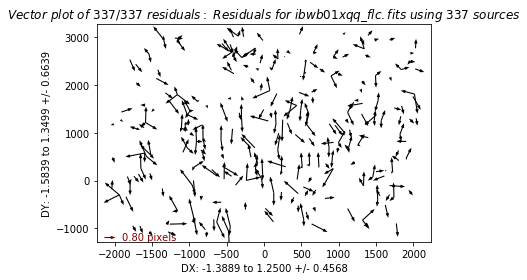

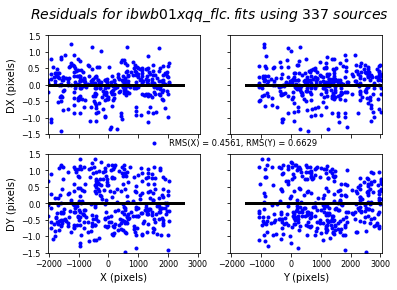

In [13]:
refcat = 'sdss.cat'
cw = 3.5  # Set to two times the FWHM of the PSF of the UVIS detector
wcsname = 'SDSS'  # Specify the WCS name for this alignment

tweakreg.TweakReg('*flc.fits',  # Pass input images
                  updatehdr=False,  # update header with new WCS solution
                  imagefindcfg={'threshold': 500., 'conv_width': cw},  # Detection parameters, threshold varies for different data
                  refcat=refcat,  # Use user supplied catalog (Gaia)
                  interactive=False,
                  see2dplot=False,
                  shiftfile=True,  # Save out shift file (so we can look at shifts later)
                  outshifts='SDSS_shifts.txt',  # name of the shift file
                  wcsname=wcsname,  # Give our WCS a new name
                  reusename=True,
                  ylimit=1.5,
                  fitgeometry='general')  # Use the 6 parameter fit

We can look at the shift file to see how well the fit did (or we could open the output png images for more information).

The columns are:
- Filename
- X Shift [pixels]
- Y Shift [pixels]
- Rotation [degrees]
- Scale
- X RMS [pixels]
- Y RMS [pixels]

In [14]:
for line in open('SDSS_shifts.txt').readlines():
    print(line)

# frame: output

# refimage: shifts_wcs.fits[wcs]

# form: delta

# units: pixels

ibwb01xrq_flc.fits    5.732565  -6.180059    0.003405     1.000069   0.474296  0.671380

ibwb01xxq_flc.fits    6.077621  -5.383191    0.000864     1.000086   0.511061  0.737972

ibwb01xqq_flc.fits    5.829134  -6.178417    0.002760     1.000079   0.456081  0.662872



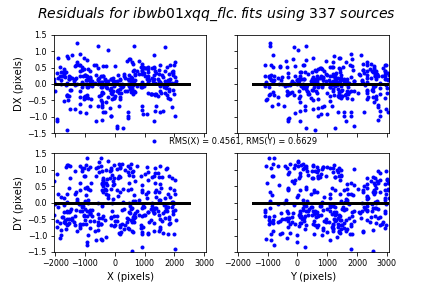

In [15]:
# Astrometric residual plots
Image(filename='residuals_ibwb01xqq_flc.png',width=500, height=300)

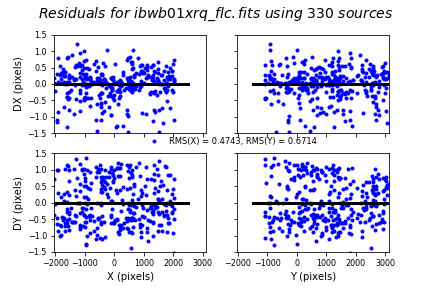

In [16]:
Image(filename='residuals_ibwb01xrq_flc.png',width=500, height=300)

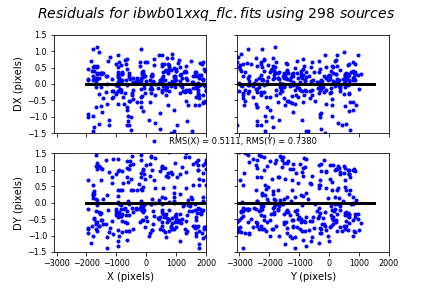

In [17]:
Image(filename='residuals_ibwb01xxq_flc.png',width=500, height=300)

As we can see, the RMS is fairly large at about 0.5 pixels, which is not a great fit. This is likely because the SDSS astrometric precision is not high enough to get good HST alignment. One approach would be to align the first image to SDSS and then align the remaining HST images to one another. This would improve both the absolute and relative alignment of the individual frames.

### 3b. Gaia Alignment

INFO:drizzlepac.util:Setting up logfile :  tweakreg.log


Setting up logfile :  tweakreg.log


INFO:drizzlepac.tweakreg:TweakReg Version 1.4.7(18-April-2018) started at: 19:21:20.577 (21/03/2019) 


TweakReg Version 1.4.7(18-April-2018) started at: 19:21:20.577 (21/03/2019) 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.util:Version Information


Version Information


INFO:drizzlepac.util:--------------------


--------------------


INFO:drizzlepac.util:Python Version [GCC 7.3.0]


Python Version [GCC 7.3.0]


INFO:drizzlepac.util:3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 


3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 


INFO:drizzlepac.util:numpy Version -> 1.15.4 


numpy Version -> 1.15.4 


INFO:drizzlepac.util:astropy Version -> 3.1.2 


astropy Version -> 3.1.2 


INFO:drizzlepac.util:stwcs Version -> 1.4.2 


stwcs Version -> 1.4.2 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS common to all Processing Steps:


INFO:drizzlepac.tweakreg:	clean :	False


INFO:drizzlepac.tweakreg:	enforce_user_order :	True


INFO:drizzlepac.tweakreg:	exclusions :	


INFO:drizzlepac.tweakreg:	expand_refcat :	False


INFO:drizzlepac.tweakreg:	input :	*flc.fits


INFO:drizzlepac.tweakreg:	interactive :	False


INFO:drizzlepac.tweakreg:	refimage :	


INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log


INFO:drizzlepac.tweakreg:	updatewcs :	False


INFO:drizzlepac.tweakreg:	verbose :	False


INFO:drizzlepac.tweakreg:	writecat :	True


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Finding shifts for: 


Finding shifts for: 


INFO:drizzlepac.tweakreg:    ibwb01xrq_flc.fits


    ibwb01xrq_flc.fits


INFO:drizzlepac.tweakreg:    ibwb01xxq_flc.fits


    ibwb01xxq_flc.fits


INFO:drizzlepac.tweakreg:    ibwb01xqq_flc.fits


    ibwb01xqq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for each input image:


INFO:drizzlepac.tweakreg:	clean :	False


INFO:drizzlepac.tweakreg:	computesig :	True


INFO:drizzlepac.tweakreg:	conv_width :	3.5


INFO:drizzlepac.tweakreg:	dqbits :	


INFO:drizzlepac.tweakreg:	enforce_user_order :	True


INFO:drizzlepac.tweakreg:	expand_refcat :	False


INFO:drizzlepac.tweakreg:	fluxmax :	None


INFO:drizzlepac.tweakreg:	fluxmin :	None


INFO:drizzlepac.tweakreg:	input :	*flc.fits


INFO:drizzlepac.tweakreg:	interactive :	False


INFO:drizzlepac.tweakreg:	nsigma :	1.5


INFO:drizzlepac.tweakreg:	peakmax :	None


INFO:drizzlepac.tweakreg:	peakmin :	None


INFO:drizzlepac.tweakreg:	ratio :	1.0


INFO:drizzlepac.tweakreg:	refimage :	


INFO:drizzlepac.tweakreg:	roundhi :	1.0


INFO:drizzlepac.tweakreg:	roundlo :	-1.0


INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log


INFO:drizzlepac.tweakreg:	sharphi :	1.0


INFO:drizzlepac.tweakreg:	sharplo :	0.2


INFO:drizzlepac.tweakreg:	skysigma :	0.0


INFO:drizzlepac.tweakreg:	theta :	0.0


INFO:drizzlepac.tweakreg:	threshold :	500.0


INFO:drizzlepac.tweakreg:	updatehdr :	False


INFO:drizzlepac.tweakreg:	updatewcs :	False


INFO:drizzlepac.tweakreg:	use_sharp_round :	False


INFO:drizzlepac.tweakreg:	verbose :	False


INFO:drizzlepac.tweakreg:	writecat :	True


INFO:drizzlepac.tweakreg:	xyunits :	pixels


INFO:drizzlepac.tweakreg:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.imgclasses:===  Source finding for image 'ibwb01xrq_flc.fits':


===  Source finding for image 'ibwb01xrq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibwb01xrq_flc.fits', EXT=('SCI', 1) started at: 19:21:20.754 (21/03/2019)


  #  Source finding for 'ibwb01xrq_flc.fits', EXT=('SCI', 1) started at: 19:21:20.754 (21/03/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 5.638966


INFO:drizzlepac.catalogs:###Source finding finished at: 19:21:21.509 (21/03/2019)


INFO:drizzlepac.catalogs:     Found 1363 objects.


     Found 1363 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'ibwb01xrq_flc.fits', EXT=('SCI', 2) started at: 19:21:21.584 (21/03/2019)


  #  Source finding for 'ibwb01xrq_flc.fits', EXT=('SCI', 2) started at: 19:21:21.584 (21/03/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 5.682907


INFO:drizzlepac.catalogs:###Source finding finished at: 19:21:22.429 (21/03/2019)


INFO:drizzlepac.catalogs:     Found 1313 objects.


     Found 1313 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibwb01xrq_flc.fits': 2676


===  FINAL number of objects in image 'ibwb01xrq_flc.fits': 2676


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibwb01xxq_flc.fits':


===  Source finding for image 'ibwb01xxq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibwb01xxq_flc.fits', EXT=('SCI', 1) started at: 19:21:22.801 (21/03/2019)


  #  Source finding for 'ibwb01xxq_flc.fits', EXT=('SCI', 1) started at: 19:21:22.801 (21/03/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 4.939314


INFO:drizzlepac.catalogs:###Source finding finished at: 19:21:23.716 (21/03/2019)


INFO:drizzlepac.catalogs:     Found 1836 objects.


     Found 1836 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'ibwb01xxq_flc.fits', EXT=('SCI', 2) started at: 19:21:23.795 (21/03/2019)


  #  Source finding for 'ibwb01xxq_flc.fits', EXT=('SCI', 2) started at: 19:21:23.795 (21/03/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 4.820505


INFO:drizzlepac.catalogs:###Source finding finished at: 19:21:24.686 (21/03/2019)


INFO:drizzlepac.catalogs:     Found 2008 objects.


     Found 2008 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibwb01xxq_flc.fits': 3844


===  FINAL number of objects in image 'ibwb01xxq_flc.fits': 3844


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibwb01xqq_flc.fits':


===  Source finding for image 'ibwb01xqq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibwb01xqq_flc.fits', EXT=('SCI', 1) started at: 19:21:24.927 (21/03/2019)


  #  Source finding for 'ibwb01xqq_flc.fits', EXT=('SCI', 1) started at: 19:21:24.927 (21/03/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 1.846397


INFO:drizzlepac.catalogs:###Source finding finished at: 19:21:25.705 (21/03/2019)


INFO:drizzlepac.catalogs:     Found 1364 objects.


     Found 1364 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'ibwb01xqq_flc.fits', EXT=('SCI', 2) started at: 19:21:25.786 (21/03/2019)


  #  Source finding for 'ibwb01xqq_flc.fits', EXT=('SCI', 2) started at: 19:21:25.786 (21/03/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 0.389856


INFO:drizzlepac.catalogs:###Source finding finished at: 19:21:26.661 (21/03/2019)


INFO:drizzlepac.catalogs:     Found 2137 objects.


     Found 2137 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibwb01xqq_flc.fits': 3501


===  FINAL number of objects in image 'ibwb01xqq_flc.fits': 3501


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for the reference image (not used):


INFO:drizzlepac.tweakreg:	clean :	False


INFO:drizzlepac.tweakreg:	computesig :	True


INFO:drizzlepac.tweakreg:	conv_width :	3.5


INFO:drizzlepac.tweakreg:	dqbits :	


INFO:drizzlepac.tweakreg:	enforce_user_order :	True


INFO:drizzlepac.tweakreg:	expand_refcat :	False


INFO:drizzlepac.tweakreg:	fluxmax :	None


INFO:drizzlepac.tweakreg:	fluxmin :	None


INFO:drizzlepac.tweakreg:	input :	*flc.fits


INFO:drizzlepac.tweakreg:	interactive :	False


INFO:drizzlepac.tweakreg:	nsigma :	1.5


INFO:drizzlepac.tweakreg:	peakmax :	None


INFO:drizzlepac.tweakreg:	peakmin :	None


INFO:drizzlepac.tweakreg:	ratio :	1.0


INFO:drizzlepac.tweakreg:	refimage :	


INFO:drizzlepac.tweakreg:	roundhi :	1.0


INFO:drizzlepac.tweakreg:	roundlo :	-1.0


INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log


INFO:drizzlepac.tweakreg:	sharphi :	1.0


INFO:drizzlepac.tweakreg:	sharplo :	0.2


INFO:drizzlepac.tweakreg:	skysigma :	0.0


INFO:drizzlepac.tweakreg:	theta :	0.0


INFO:drizzlepac.tweakreg:	threshold :	4.0


INFO:drizzlepac.tweakreg:	updatehdr :	False


INFO:drizzlepac.tweakreg:	updatewcs :	False


INFO:drizzlepac.tweakreg:	use_sharp_round :	False


INFO:drizzlepac.tweakreg:	verbose :	False


INFO:drizzlepac.tweakreg:	writecat :	True


INFO:drizzlepac.tweakreg:	xyunits :	pixels


INFO:drizzlepac.imgclasses:Converting RA/Dec positions of reference sources from "ibwb01xrq_flc.fits" to X,Y positions in reference WCS...


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:Performing alignment in the projection plane defined by the WCS


Performing alignment in the projection plane defined by the WCS


INFO:drizzlepac.tweakreg:derived from 'ibwb01xrq_flc.fits'


derived from 'ibwb01xrq_flc.fits'


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for matching sources:


INFO:drizzlepac.tweakreg:	minobj :	15


INFO:drizzlepac.tweakreg:	residplot :	both


INFO:drizzlepac.tweakreg:	searchrad :	1.0


INFO:drizzlepac.tweakreg:	searchunits :	arcseconds


INFO:drizzlepac.tweakreg:	see2dplot :	False


INFO:drizzlepac.tweakreg:	separation :	0.5


INFO:drizzlepac.tweakreg:	tolerance :	1.0


INFO:drizzlepac.tweakreg:	use2dhist :	True


INFO:drizzlepac.tweakreg:	xoffset :	0.0


INFO:drizzlepac.tweakreg:	yoffset :	0.0


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for fitting source lists:


INFO:drizzlepac.tweakreg:	fitgeometry :	general


INFO:drizzlepac.tweakreg:	labelsize :	8


INFO:drizzlepac.tweakreg:	minobj :	15


INFO:drizzlepac.tweakreg:	nclip :	3


INFO:drizzlepac.tweakreg:	residplot :	both


INFO:drizzlepac.tweakreg:	sigma :	2.3


INFO:drizzlepac.tweakreg:	ylimit :	0.2


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for creating a shiftfile:


INFO:drizzlepac.tweakreg:	outshifts :	Gaia_shifts.txt


INFO:drizzlepac.tweakreg:	outwcs :	shifts_wcs.fits


INFO:drizzlepac.tweakreg:	shiftfile :	True


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibwb01xrq_flc.fits


Performing fit for: ibwb01xrq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibwb01xrq_flc.fits' with sources from reference catalog 'gaia.cat'


Matching sources from 'ibwb01xrq_flc.fits' with sources from reference catalog 'gaia.cat'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  3.8069648732932144 -6.212865155035395


Found initial X and Y shifts of  3.8069648732932144 -6.212865155035395


INFO:drizzlepac.tweakutils:    with significance of  4024.131352584945 and  622.0  matches


    with significance of  4024.131352584945 and  622.0  matches


INFO:drizzlepac.imgclasses:Found 695 matches for ibwb01xrq_flc.fits...


Found 695 matches for ibwb01xrq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.imgclasses:Computed  general  fit for  ibwb01xrq_flc.fits : 


Computed  general  fit for  ibwb01xrq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 4.4304  YSH: -5.6525    PROPER ROT: 0.004753510993    


XSH: 4.4304  YSH: -5.6525    PROPER ROT: 0.004753510993    


INFO:drizzlepac.imgclasses:<ROT>: 0.004753510993  SKEW: 0.0001816106844    ROT_X: 0.004662705651  ROT_Y: 0.004844316335


<ROT>: 0.004753510993  SKEW: 0.0001816106844    ROT_X: 0.004662705651  ROT_Y: 0.004844316335


INFO:drizzlepac.imgclasses:<SCALE>: 1.000087233  SCALE_X: 1.000079089  SCALE_Y: 1.000095376


<SCALE>: 1.000087233  SCALE_X: 1.000079089  SCALE_Y: 1.000095376


INFO:drizzlepac.imgclasses:XRMS: 0.034    YRMS: 0.045


XRMS: 0.034    YRMS: 0.045


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 7.8e-07 (deg)   RMS_DEC: 3.3e-08 (deg)


RMS_RA: 7.8e-07 (deg)   RMS_DEC: 3.3e-08 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  536  objects.


Final solution based on  536  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ibwb01xrq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  ibwb01xrq_flc_catalog_fit.match


wrote XY data to:  ibwb01xrq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  536


Total # points:  536


INFO:drizzlepac.tweakutils:# of points after clipping:  536


# of points after clipping:  536


INFO:drizzlepac.tweakutils:Total # points:  536


Total # points:  536


INFO:drizzlepac.tweakutils:# of points after clipping:  536


# of points after clipping:  536


INFO:drizzlepac.updatehdr:....Updating header for ibwb01xrq_flc.fits...


INFO:drizzlepac.updatehdr:Processing ibwb01xrq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:Updating header for ibwb01xrq_flc.fits[1]


INFO:drizzlepac.updatehdr:Processing ibwb01xrq_flc.fits['SCI',2]


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for ibwb01xrq_flc.fits[4]


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibwb01xxq_flc.fits


Performing fit for: ibwb01xxq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibwb01xxq_flc.fits' with sources from reference catalog 'gaia.cat'


Matching sources from 'ibwb01xxq_flc.fits' with sources from reference catalog 'gaia.cat'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  4.462318472044721 -5.259238414182825


Found initial X and Y shifts of  4.462318472044721 -5.259238414182825


INFO:drizzlepac.tweakutils:    with significance of  2263.2462320413383 and  444.0  matches


    with significance of  2263.2462320413383 and  444.0  matches


INFO:drizzlepac.imgclasses:Found 656 matches for ibwb01xxq_flc.fits...


Found 656 matches for ibwb01xxq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.imgclasses:Computed  general  fit for  ibwb01xxq_flc.fits : 


Computed  general  fit for  ibwb01xxq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 4.8730  YSH: -4.8452    PROPER ROT: 0.002541929447    


XSH: 4.8730  YSH: -4.8452    PROPER ROT: 0.002541929447    


INFO:drizzlepac.imgclasses:<ROT>: 0.002541929447  SKEW: 0.0002640895714    ROT_X: 0.002409884661  ROT_Y: 0.002673974232


<ROT>: 0.002541929447  SKEW: 0.0002640895714    ROT_X: 0.002409884661  ROT_Y: 0.002673974232


INFO:drizzlepac.imgclasses:<SCALE>: 1.000089245  SCALE_X: 1.000080462  SCALE_Y: 1.000098028


<SCALE>: 1.000089245  SCALE_X: 1.000080462  SCALE_Y: 1.000098028


INFO:drizzlepac.imgclasses:XRMS: 0.032    YRMS: 0.046


XRMS: 0.032    YRMS: 0.046


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 7.8e-07 (deg)   RMS_DEC: 1.2e-08 (deg)


RMS_RA: 7.8e-07 (deg)   RMS_DEC: 1.2e-08 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  506  objects.


Final solution based on  506  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ibwb01xxq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  ibwb01xxq_flc_catalog_fit.match


wrote XY data to:  ibwb01xxq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  506


Total # points:  506


INFO:drizzlepac.tweakutils:# of points after clipping:  506


# of points after clipping:  506


INFO:drizzlepac.tweakutils:Total # points:  506


Total # points:  506


INFO:drizzlepac.tweakutils:# of points after clipping:  506


# of points after clipping:  506


INFO:drizzlepac.updatehdr:....Updating header for ibwb01xxq_flc.fits...


INFO:drizzlepac.updatehdr:Processing ibwb01xxq_flc.fits['SCI',1]


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for ibwb01xxq_flc.fits[1]


INFO:drizzlepac.updatehdr:Processing ibwb01xxq_flc.fits['SCI',2]


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for ibwb01xxq_flc.fits[4]


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibwb01xqq_flc.fits


Performing fit for: ibwb01xqq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibwb01xqq_flc.fits' with sources from reference catalog 'gaia.cat'


Matching sources from 'ibwb01xqq_flc.fits' with sources from reference catalog 'gaia.cat'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  3.8727034032608714 -6.213583191500298


Found initial X and Y shifts of  3.8727034032608714 -6.213583191500298


INFO:drizzlepac.tweakutils:    with significance of  3291.4481026206226 and  547.0  matches


    with significance of  3291.4481026206226 and  547.0  matches


INFO:drizzlepac.imgclasses:Found 643 matches for ibwb01xqq_flc.fits...


Found 643 matches for ibwb01xqq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.imgclasses:Computed  general  fit for  ibwb01xqq_flc.fits : 


Computed  general  fit for  ibwb01xqq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 4.4865  YSH: -5.6699    PROPER ROT: 0.00466695482    


XSH: 4.4865  YSH: -5.6699    PROPER ROT: 0.00466695482    


INFO:drizzlepac.imgclasses:<ROT>: 0.00466695482  SKEW: 0.0003381052089    ROT_X: 0.004497902215  ROT_Y: 0.004836007424


<ROT>: 0.00466695482  SKEW: 0.0003381052089    ROT_X: 0.004497902215  ROT_Y: 0.004836007424


INFO:drizzlepac.imgclasses:<SCALE>: 1.00008863  SCALE_X: 1.000080363  SCALE_Y: 1.000096898


<SCALE>: 1.00008863  SCALE_X: 1.000080363  SCALE_Y: 1.000096898


INFO:drizzlepac.imgclasses:XRMS: 0.024    YRMS: 0.024


XRMS: 0.024    YRMS: 0.024


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 4.6e-07 (deg)   RMS_DEC: 7.6e-08 (deg)


RMS_RA: 4.6e-07 (deg)   RMS_DEC: 7.6e-08 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  515  objects.


Final solution based on  515  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ibwb01xqq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  ibwb01xqq_flc_catalog_fit.match


wrote XY data to:  ibwb01xqq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  515


Total # points:  515


INFO:drizzlepac.tweakutils:# of points after clipping:  515


# of points after clipping:  515


INFO:drizzlepac.tweakutils:Total # points:  515


Total # points:  515


INFO:drizzlepac.tweakutils:# of points after clipping:  515


# of points after clipping:  515


INFO:drizzlepac.updatehdr:....Updating header for ibwb01xqq_flc.fits...


INFO:drizzlepac.updatehdr:Processing ibwb01xqq_flc.fits['SCI',1]


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for ibwb01xqq_flc.fits[1]


INFO:drizzlepac.updatehdr:Processing ibwb01xqq_flc.fits['SCI',2]


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for ibwb01xqq_flc.fits[4]


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.tweakutils:Writing out shiftfile : Gaia_shifts.txt


Writing out shiftfile : Gaia_shifts.txt


INFO:drizzlepac.util:Trailer file written to:  tweakreg.log


Trailer file written to:  tweakreg.log


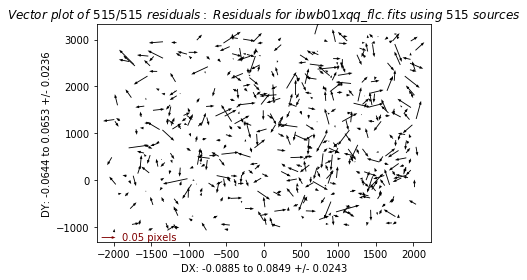

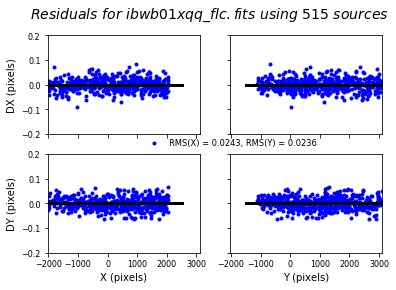

In [18]:
refcat = 'gaia.cat'
cw = 3.5  # Set to two times the FWHM of the PSF.
wcsname = 'Gaia'  # Specify the WCS name for this alignment

tweakreg.TweakReg('*flc.fits',  # Pass input images
                  updatehdr=False,  # update header with new WCS solution
                  imagefindcfg={'threshold':500.,'conv_width':cw},  # Detection parameters, threshold varies for different data
                  refcat=refcat,  # Use user supplied catalog (Gaia)
                  interactive=False,
                  see2dplot=False,
                  shiftfile=True,  # Save out shift file (so we can look at shifts later)
                  outshifts='Gaia_shifts.txt',  # name of the shift file
                  wcsname=wcsname,  # Give our WCS a new name
                  reusename=True,
                  sigma=2.3,
                  ylimit=0.2,
                  fitgeometry='general')  # Use the 6 parameter fit

We can similarly look at the shift file from alignment to the Gaia catalog:

In [19]:
for line in open('Gaia_shifts.txt').readlines():
    print(line)

# frame: output

# refimage: shifts_wcs.fits[wcs]

# form: delta

# units: pixels

ibwb01xrq_flc.fits    4.430405  -5.652466    0.004754     1.000087   0.033929  0.044934

ibwb01xxq_flc.fits    4.873043  -4.845222    0.002542     1.000089   0.032130  0.045748

ibwb01xqq_flc.fits    4.486548  -5.669864    0.004667     1.000089   0.024270  0.023605



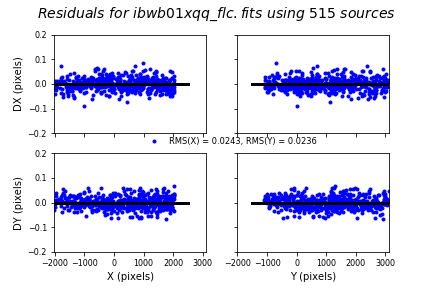

In [20]:
# Astrometric residual plots
Image(filename='residuals_ibwb01xqq_flc.png',width=500, height=300)

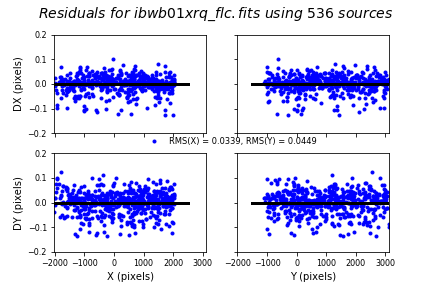

In [21]:
Image(filename='residuals_ibwb01xrq_flc.png',width=500, height=300)

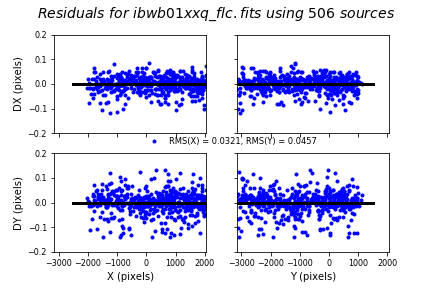

In [22]:
Image(filename='residuals_ibwb01xxq_flc.png',width=500, height=300)

As expected, the Gaia catalog does quite a bit better, with rms residuals less tha 0.05 pixels.  

To apply these transformations to the image, we simply need to run TweakReg the same as before, but set the parameter `updatehdr` equal to `True`:

INFO:drizzlepac.util:Setting up logfile :  tweakreg.log


Setting up logfile :  tweakreg.log


INFO:drizzlepac.tweakreg:TweakReg Version 1.4.7(18-April-2018) started at: 19:21:29.398 (21/03/2019) 


TweakReg Version 1.4.7(18-April-2018) started at: 19:21:29.398 (21/03/2019) 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.util:Version Information


Version Information


INFO:drizzlepac.util:--------------------


--------------------


INFO:drizzlepac.util:Python Version [GCC 7.3.0]


Python Version [GCC 7.3.0]


INFO:drizzlepac.util:3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 


3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 


INFO:drizzlepac.util:numpy Version -> 1.15.4 


numpy Version -> 1.15.4 


INFO:drizzlepac.util:astropy Version -> 3.1.2 


astropy Version -> 3.1.2 


INFO:drizzlepac.util:stwcs Version -> 1.4.2 


stwcs Version -> 1.4.2 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS common to all Processing Steps:


INFO:drizzlepac.tweakreg:	clean :	False


INFO:drizzlepac.tweakreg:	enforce_user_order :	True


INFO:drizzlepac.tweakreg:	exclusions :	


INFO:drizzlepac.tweakreg:	expand_refcat :	False


INFO:drizzlepac.tweakreg:	input :	*flc.fits


INFO:drizzlepac.tweakreg:	interactive :	False


INFO:drizzlepac.tweakreg:	refimage :	


INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log


INFO:drizzlepac.tweakreg:	updatewcs :	False


INFO:drizzlepac.tweakreg:	verbose :	False


INFO:drizzlepac.tweakreg:	writecat :	True


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Finding shifts for: 


Finding shifts for: 


INFO:drizzlepac.tweakreg:    ibwb01xrq_flc.fits


    ibwb01xrq_flc.fits


INFO:drizzlepac.tweakreg:    ibwb01xxq_flc.fits


    ibwb01xxq_flc.fits


INFO:drizzlepac.tweakreg:    ibwb01xqq_flc.fits


    ibwb01xqq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for each input image:


INFO:drizzlepac.tweakreg:	clean :	False


INFO:drizzlepac.tweakreg:	computesig :	True


INFO:drizzlepac.tweakreg:	conv_width :	3.5


INFO:drizzlepac.tweakreg:	dqbits :	


INFO:drizzlepac.tweakreg:	enforce_user_order :	True


INFO:drizzlepac.tweakreg:	expand_refcat :	False


INFO:drizzlepac.tweakreg:	fluxmax :	None


INFO:drizzlepac.tweakreg:	fluxmin :	None


INFO:drizzlepac.tweakreg:	input :	*flc.fits


INFO:drizzlepac.tweakreg:	interactive :	False


INFO:drizzlepac.tweakreg:	nsigma :	1.5


INFO:drizzlepac.tweakreg:	peakmax :	None


INFO:drizzlepac.tweakreg:	peakmin :	None


INFO:drizzlepac.tweakreg:	ratio :	1.0


INFO:drizzlepac.tweakreg:	refimage :	


INFO:drizzlepac.tweakreg:	roundhi :	1.0


INFO:drizzlepac.tweakreg:	roundlo :	-1.0


INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log


INFO:drizzlepac.tweakreg:	sharphi :	1.0


INFO:drizzlepac.tweakreg:	sharplo :	0.2


INFO:drizzlepac.tweakreg:	skysigma :	0.0


INFO:drizzlepac.tweakreg:	theta :	0.0


INFO:drizzlepac.tweakreg:	threshold :	500.0


INFO:drizzlepac.tweakreg:	updatehdr :	True


INFO:drizzlepac.tweakreg:	updatewcs :	False


INFO:drizzlepac.tweakreg:	use_sharp_round :	False


INFO:drizzlepac.tweakreg:	verbose :	False


INFO:drizzlepac.tweakreg:	writecat :	True


INFO:drizzlepac.tweakreg:	xyunits :	pixels


INFO:drizzlepac.tweakreg:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.imgclasses:===  Source finding for image 'ibwb01xrq_flc.fits':


===  Source finding for image 'ibwb01xrq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibwb01xrq_flc.fits', EXT=('SCI', 1) started at: 19:21:29.564 (21/03/2019)


  #  Source finding for 'ibwb01xrq_flc.fits', EXT=('SCI', 1) started at: 19:21:29.564 (21/03/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 5.638966


INFO:drizzlepac.catalogs:###Source finding finished at: 19:21:30.311 (21/03/2019)


INFO:drizzlepac.catalogs:     Found 1363 objects.


     Found 1363 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'ibwb01xrq_flc.fits', EXT=('SCI', 2) started at: 19:21:30.392 (21/03/2019)


  #  Source finding for 'ibwb01xrq_flc.fits', EXT=('SCI', 2) started at: 19:21:30.392 (21/03/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 5.682907


INFO:drizzlepac.catalogs:###Source finding finished at: 19:21:31.17 (21/03/2019)


INFO:drizzlepac.catalogs:     Found 1313 objects.


     Found 1313 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibwb01xrq_flc.fits': 2676


===  FINAL number of objects in image 'ibwb01xrq_flc.fits': 2676


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibwb01xxq_flc.fits':


===  Source finding for image 'ibwb01xxq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibwb01xxq_flc.fits', EXT=('SCI', 1) started at: 19:21:31.511 (21/03/2019)


  #  Source finding for 'ibwb01xxq_flc.fits', EXT=('SCI', 1) started at: 19:21:31.511 (21/03/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 4.939314


INFO:drizzlepac.catalogs:###Source finding finished at: 19:21:32.399 (21/03/2019)


INFO:drizzlepac.catalogs:     Found 1836 objects.


     Found 1836 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'ibwb01xxq_flc.fits', EXT=('SCI', 2) started at: 19:21:32.481 (21/03/2019)


  #  Source finding for 'ibwb01xxq_flc.fits', EXT=('SCI', 2) started at: 19:21:32.481 (21/03/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 4.820505

INFO:drizzlepac.catalogs:###Source finding finished at: 19:21:33.304 (21/03/2019)


INFO:drizzlepac.catalogs:     Found 2008 objects.


     Found 2008 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibwb01xxq_flc.fits': 3844


===  FINAL number of objects in image 'ibwb01xxq_flc.fits': 3844


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibwb01xqq_flc.fits':


===  Source finding for image 'ibwb01xqq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibwb01xqq_flc.fits', EXT=('SCI', 1) started at: 19:21:33.590 (21/03/2019)


  #  Source finding for 'ibwb01xqq_flc.fits', EXT=('SCI', 1) started at: 19:21:33.590 (21/03/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 1.846397


INFO:drizzlepac.catalogs:###Source finding finished at: 19:21:34.429 (21/03/2019)


INFO:drizzlepac.catalogs:     Found 1364 objects.


     Found 1364 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'ibwb01xqq_flc.fits', EXT=('SCI', 2) started at: 19:21:34.50 (21/03/2019)


  #  Source finding for 'ibwb01xqq_flc.fits', EXT=('SCI', 2) started at: 19:21:34.50 (21/03/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 0.389856


INFO:drizzlepac.catalogs:###Source finding finished at: 19:21:35.303 (21/03/2019)


INFO:drizzlepac.catalogs:     Found 2137 objects.


     Found 2137 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibwb01xqq_flc.fits': 3501


===  FINAL number of objects in image 'ibwb01xqq_flc.fits': 3501


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for the reference image (not used):


INFO:drizzlepac.tweakreg:	clean :	False


INFO:drizzlepac.tweakreg:	computesig :	True


INFO:drizzlepac.tweakreg:	conv_width :	3.5


INFO:drizzlepac.tweakreg:	dqbits :	


INFO:drizzlepac.tweakreg:	enforce_user_order :	True


INFO:drizzlepac.tweakreg:	expand_refcat :	False


INFO:drizzlepac.tweakreg:	fluxmax :	None


INFO:drizzlepac.tweakreg:	fluxmin :	None


INFO:drizzlepac.tweakreg:	input :	*flc.fits


INFO:drizzlepac.tweakreg:	interactive :	False


INFO:drizzlepac.tweakreg:	nsigma :	1.5


INFO:drizzlepac.tweakreg:	peakmax :	None


INFO:drizzlepac.tweakreg:	peakmin :	None


INFO:drizzlepac.tweakreg:	ratio :	1.0


INFO:drizzlepac.tweakreg:	refimage :	


INFO:drizzlepac.tweakreg:	roundhi :	1.0


INFO:drizzlepac.tweakreg:	roundlo :	-1.0


INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log


INFO:drizzlepac.tweakreg:	sharphi :	1.0


INFO:drizzlepac.tweakreg:	sharplo :	0.2


INFO:drizzlepac.tweakreg:	skysigma :	0.0


INFO:drizzlepac.tweakreg:	theta :	0.0


INFO:drizzlepac.tweakreg:	threshold :	4.0


INFO:drizzlepac.tweakreg:	updatehdr :	False


INFO:drizzlepac.tweakreg:	updatewcs :	False


INFO:drizzlepac.tweakreg:	use_sharp_round :	False


INFO:drizzlepac.tweakreg:	verbose :	False


INFO:drizzlepac.tweakreg:	writecat :	True


INFO:drizzlepac.tweakreg:	xyunits :	pixels


INFO:drizzlepac.imgclasses:Converting RA/Dec positions of reference sources from "ibwb01xrq_flc.fits" to X,Y positions in reference WCS...


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:Performing alignment in the projection plane defined by the WCS


Performing alignment in the projection plane defined by the WCS


INFO:drizzlepac.tweakreg:derived from 'ibwb01xrq_flc.fits'


derived from 'ibwb01xrq_flc.fits'


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for matching sources:


INFO:drizzlepac.tweakreg:	minobj :	15


INFO:drizzlepac.tweakreg:	residplot :	both


INFO:drizzlepac.tweakreg:	searchrad :	1.0


INFO:drizzlepac.tweakreg:	searchunits :	arcseconds


INFO:drizzlepac.tweakreg:	see2dplot :	False


INFO:drizzlepac.tweakreg:	separation :	0.5


INFO:drizzlepac.tweakreg:	tolerance :	1.0


INFO:drizzlepac.tweakreg:	use2dhist :	True


INFO:drizzlepac.tweakreg:	xoffset :	0.0


INFO:drizzlepac.tweakreg:	yoffset :	0.0


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for fitting source lists:


INFO:drizzlepac.tweakreg:	fitgeometry :	general


INFO:drizzlepac.tweakreg:	labelsize :	8


INFO:drizzlepac.tweakreg:	minobj :	15


INFO:drizzlepac.tweakreg:	nclip :	3


INFO:drizzlepac.tweakreg:	residplot :	both


INFO:drizzlepac.tweakreg:	sigma :	2.3


INFO:drizzlepac.tweakreg:	ylimit :	None


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for creating a shiftfile:


INFO:drizzlepac.tweakreg:	outshifts :	Gaia_shifts.txt


INFO:drizzlepac.tweakreg:	outwcs :	shifts_wcs.fits


INFO:drizzlepac.tweakreg:	shiftfile :	True


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibwb01xrq_flc.fits


Performing fit for: ibwb01xrq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibwb01xrq_flc.fits' with sources from reference catalog 'gaia.cat'


Matching sources from 'ibwb01xrq_flc.fits' with sources from reference catalog 'gaia.cat'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  3.8069648732932144 -6.212865155035395


Found initial X and Y shifts of  3.8069648732932144 -6.212865155035395


INFO:drizzlepac.tweakutils:    with significance of  4024.131352584945 and  622.0  matches


    with significance of  4024.131352584945 and  622.0  matches


INFO:drizzlepac.imgclasses:Found 695 matches for ibwb01xrq_flc.fits...


Found 695 matches for ibwb01xrq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.imgclasses:Computed  general  fit for  ibwb01xrq_flc.fits : 


Computed  general  fit for  ibwb01xrq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 4.4304  YSH: -5.6525    PROPER ROT: 0.004753510993    


XSH: 4.4304  YSH: -5.6525    PROPER ROT: 0.004753510993    


INFO:drizzlepac.imgclasses:<ROT>: 0.004753510993  SKEW: 0.0001816106844    ROT_X: 0.004662705651  ROT_Y: 0.004844316335


<ROT>: 0.004753510993  SKEW: 0.0001816106844    ROT_X: 0.004662705651  ROT_Y: 0.004844316335


INFO:drizzlepac.imgclasses:<SCALE>: 1.000087233  SCALE_X: 1.000079089  SCALE_Y: 1.000095376


<SCALE>: 1.000087233  SCALE_X: 1.000079089  SCALE_Y: 1.000095376


INFO:drizzlepac.imgclasses:XRMS: 0.034    YRMS: 0.045


XRMS: 0.034    YRMS: 0.045


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 7.8e-07 (deg)   RMS_DEC: 3.3e-08 (deg)


RMS_RA: 7.8e-07 (deg)   RMS_DEC: 3.3e-08 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  536  objects.


Final solution based on  536  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ibwb01xrq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  ibwb01xrq_flc_catalog_fit.match


wrote XY data to:  ibwb01xrq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  536


Total # points:  536


INFO:drizzlepac.tweakutils:# of points after clipping:  536


# of points after clipping:  536


INFO:drizzlepac.tweakutils:Total # points:  536


Total # points:  536


INFO:drizzlepac.tweakutils:# of points after clipping:  536


# of points after clipping:  536


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for ibwb01xrq_flc.fits...


....Updating header for ibwb01xrq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ibwb01xrq_flc.fits['SCI',1]


Processing ibwb01xrq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for ibwb01xrq_flc.fits[1]


Updating header for ibwb01xrq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -6.71446647044927e-06 -9.202473900248697e-06


CD_11  CD_12: -6.71446647044927e-06 -9.202473900248697e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -8.798330091535116e-06 6.145226560800136e-06


CD_21  CD_22: -8.798330091535116e-06 6.145226560800136e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 290.23990173005535 37.794734767309585


CRVAL    : 290.23990173005535 37.794734767309585


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1026.0


CRPIX    : 2048.0 1026.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2051


NAXIS    : 4096 2051


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.0398469929515555


Plate Scale : 0.0398469929515555


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -56.265799627618115


ORIENTAT : -56.265799627618115


INFO:drizzlepac.updatehdr:WCSNAME  :  Gaia


WCSNAME  :  Gaia


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ibwb01xrq_flc.fits['SCI',2]


Processing ibwb01xrq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for ibwb01xrq_flc.fits[4]


Updating header for ibwb01xrq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -6.731551476353703e-06 -9.088357446866722e-06


CD_11  CD_12: -6.731551476353703e-06 -9.088357446866722e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -8.708078818825288e-06 6.080698397469663e-06


CD_21  CD_22: -8.708078818825288e-06 6.080698397469663e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 290.21581136797266 37.80746913586603


CRVAL    : 290.21581136797266 37.80746913586603


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1026.0


CRPIX    : 2048.0 1026.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2051


NAXIS    : 4096 2051


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.03962677037287118


Plate Scale : 0.03962677037287118


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -56.2149198638164


ORIENTAT : -56.2149198638164


INFO:drizzlepac.updatehdr:WCSNAME  :  Gaia


WCSNAME  :  Gaia


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "Gaia"


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



  keyword), VerifyWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



  keyword), VerifyWarning)



INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibwb01xxq_flc.fits


Performing fit for: ibwb01xxq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibwb01xxq_flc.fits' with sources from reference catalog 'gaia.cat'


Matching sources from 'ibwb01xxq_flc.fits' with sources from reference catalog 'gaia.cat'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  4.462318472044721 -5.259238414182825


Found initial X and Y shifts of  4.462318472044721 -5.259238414182825


INFO:drizzlepac.tweakutils:    with significance of  2263.2462320413383 and  444.0  matches


    with significance of  2263.2462320413383 and  444.0  matches


INFO:drizzlepac.imgclasses:Found 656 matches for ibwb01xxq_flc.fits...


Found 656 matches for ibwb01xxq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.imgclasses:Computed  general  fit for  ibwb01xxq_flc.fits : 


Computed  general  fit for  ibwb01xxq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 4.8730  YSH: -4.8452    PROPER ROT: 0.002541929447    


XSH: 4.8730  YSH: -4.8452    PROPER ROT: 0.002541929447    


INFO:drizzlepac.imgclasses:<ROT>: 0.002541929447  SKEW: 0.0002640895714    ROT_X: 0.002409884661  ROT_Y: 0.002673974232


<ROT>: 0.002541929447  SKEW: 0.0002640895714    ROT_X: 0.002409884661  ROT_Y: 0.002673974232


INFO:drizzlepac.imgclasses:<SCALE>: 1.000089245  SCALE_X: 1.000080462  SCALE_Y: 1.000098028


<SCALE>: 1.000089245  SCALE_X: 1.000080462  SCALE_Y: 1.000098028


INFO:drizzlepac.imgclasses:XRMS: 0.032    YRMS: 0.046


XRMS: 0.032    YRMS: 0.046


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 7.8e-07 (deg)   RMS_DEC: 1.2e-08 (deg)


RMS_RA: 7.8e-07 (deg)   RMS_DEC: 1.2e-08 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  506  objects.


Final solution based on  506  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ibwb01xxq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  ibwb01xxq_flc_catalog_fit.match


wrote XY data to:  ibwb01xxq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  506


Total # points:  506


INFO:drizzlepac.tweakutils:# of points after clipping:  506


# of points after clipping:  506


INFO:drizzlepac.tweakutils:Total # points:  506


Total # points:  506


INFO:drizzlepac.tweakutils:# of points after clipping:  506


# of points after clipping:  506


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for ibwb01xxq_flc.fits...


....Updating header for ibwb01xxq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ibwb01xxq_flc.fits['SCI',1]


Processing ibwb01xxq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for ibwb01xxq_flc.fits[1]


Updating header for ibwb01xxq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -6.716385612494976e-06 -9.201156249348343e-06


CD_11  CD_12: -6.716385612494976e-06 -9.201156249348343e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -8.796908593114044e-06 6.147237627476968e-06


CD_21  CD_22: -8.796908593114044e-06 6.147237627476968e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 290.263740029282 37.78211826934533


CRVAL    : 290.263740029282 37.78211826934533


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1026.0


CRPIX    : 2048.0 1026.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2051


NAXIS    : 4096 2051


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.039847175433057117


Plate Scale : 0.039847175433057117


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -56.25335123852706


ORIENTAT : -56.25335123852706


INFO:drizzlepac.updatehdr:WCSNAME  :  Gaia


WCSNAME  :  Gaia


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ibwb01xxq_flc.fits['SCI',2]


Processing ibwb01xxq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for ibwb01xxq_flc.fits[4]


Updating header for ibwb01xxq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -6.733452415409884e-06 -9.087052615972346e-06


CD_11  CD_12: -6.733452415409884e-06 -9.087052615972346e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -8.70665227122253e-06 6.082685990210573e-06


CD_21  CD_22: -8.70665227122253e-06 6.082685990210573e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 290.23965723662405 37.79485679923986


CRVAL    : 290.23965723662405 37.79485679923986


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1026.0


CRPIX    : 2048.0 1026.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2051


NAXIS    : 4096 2051


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.039626951860556925


Plate Scale : 0.039626951860556925


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -56.20246232994584


ORIENTAT : -56.20246232994584


INFO:drizzlepac.updatehdr:WCSNAME  :  Gaia


WCSNAME  :  Gaia


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "Gaia"


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



  keyword), VerifyWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



  keyword), VerifyWarning)



INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibwb01xqq_flc.fits


Performing fit for: ibwb01xqq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibwb01xqq_flc.fits' with sources from reference catalog 'gaia.cat'


Matching sources from 'ibwb01xqq_flc.fits' with sources from reference catalog 'gaia.cat'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  3.8727034032608714 -6.213583191500298


Found initial X and Y shifts of  3.8727034032608714 -6.213583191500298


INFO:drizzlepac.tweakutils:    with significance of  3291.4481026206226 and  547.0  matches


    with significance of  3291.4481026206226 and  547.0  matches


INFO:drizzlepac.imgclasses:Found 643 matches for ibwb01xqq_flc.fits...


Found 643 matches for ibwb01xqq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.linearfit:Performing "general" fit


INFO:drizzlepac.imgclasses:Computed  general  fit for  ibwb01xqq_flc.fits : 


Computed  general  fit for  ibwb01xqq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 4.4865  YSH: -5.6699    PROPER ROT: 0.00466695482    


XSH: 4.4865  YSH: -5.6699    PROPER ROT: 0.00466695482    


INFO:drizzlepac.imgclasses:<ROT>: 0.00466695482  SKEW: 0.0003381052089    ROT_X: 0.004497902215  ROT_Y: 0.004836007424


<ROT>: 0.00466695482  SKEW: 0.0003381052089    ROT_X: 0.004497902215  ROT_Y: 0.004836007424


INFO:drizzlepac.imgclasses:<SCALE>: 1.00008863  SCALE_X: 1.000080363  SCALE_Y: 1.000096898


<SCALE>: 1.00008863  SCALE_X: 1.000080363  SCALE_Y: 1.000096898


INFO:drizzlepac.imgclasses:XRMS: 0.024    YRMS: 0.024


XRMS: 0.024    YRMS: 0.024


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 4.6e-07 (deg)   RMS_DEC: 7.6e-08 (deg)


RMS_RA: 4.6e-07 (deg)   RMS_DEC: 7.6e-08 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  515  objects.


Final solution based on  515  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ibwb01xqq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  ibwb01xqq_flc_catalog_fit.match


wrote XY data to:  ibwb01xqq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  515


Total # points:  515


INFO:drizzlepac.tweakutils:# of points after clipping:  515


# of points after clipping:  515


INFO:drizzlepac.tweakutils:Total # points:  515


Total # points:  515


INFO:drizzlepac.tweakutils:# of points after clipping:  515


# of points after clipping:  515


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for ibwb01xqq_flc.fits...


....Updating header for ibwb01xqq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ibwb01xqq_flc.fits['SCI',1]


Processing ibwb01xqq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for ibwb01xqq_flc.fits[1]


Updating header for ibwb01xqq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -6.714433385571139e-06 -9.202463229325017e-06


CD_11  CD_12: -6.714433385571139e-06 -9.202463229325017e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -8.798339255465083e-06 6.145217527025753e-06


CD_21  CD_22: -8.798339255465083e-06 6.145217527025753e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 290.2399019657113 37.79473538676436


CRVAL    : 290.2399019657113 37.79473538676436


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1026.0


CRPIX    : 2048.0 1026.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2051


NAXIS    : 4096 2051


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.039847004058886186


Plate Scale : 0.039847004058886186


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -56.265807843185634


ORIENTAT : -56.265807843185634


INFO:drizzlepac.updatehdr:WCSNAME  :  Gaia


WCSNAME  :  Gaia


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ibwb01xqq_flc.fits['SCI',2]


Processing ibwb01xqq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for ibwb01xqq_flc.fits[4]


Updating header for ibwb01xqq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -6.73151851585775e-06 -9.088346940181416e-06


CD_11  CD_12: -6.73151851585775e-06 -9.088346940181416e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -8.708087974035102e-06 6.080689484195719e-06


CD_21  CD_22: -8.708087974035102e-06 6.080689484195719e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 290.2158116313008 37.80746973664297


CRVAL    : 290.2158116313008 37.80746973664297


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1026.0


CRPIX    : 2048.0 1026.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2051


NAXIS    : 4096 2051


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.03962678141881469


Plate Scale : 0.03962678141881469


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -56.2149280667434


ORIENTAT : -56.2149280667434


INFO:drizzlepac.updatehdr:WCSNAME  :  Gaia


WCSNAME  :  Gaia


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "Gaia"


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



  keyword), VerifyWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



  keyword), VerifyWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.tweakutils:Writing out shiftfile : Gaia_shifts.txt


Writing out shiftfile : Gaia_shifts.txt


INFO:drizzlepac.util:Trailer file written to:  tweakreg.log


Trailer file written to:  tweakreg.log


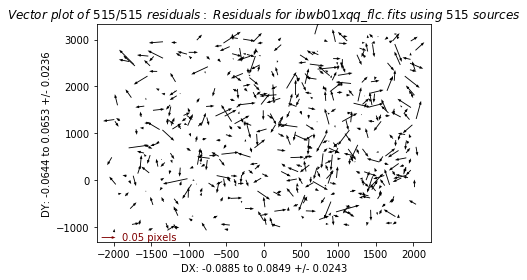

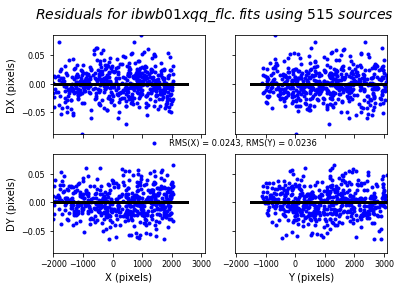

In [23]:
refcat = 'gaia.cat'
cw = 3.5  # Set to two times the FWHM of the PSF.
wcsname = 'Gaia'  # Specify the WCS name for this alignment

tweakreg.TweakReg('*flc.fits',  # Pass input images
                  updatehdr=True,  # update header with new WCS solution
                  imagefindcfg={'threshold': 500., 'conv_width': cw},  # Detection parameters, threshold varies for different data
                  refcat=refcat,  # Use user supplied catalog (Gaia)
                  interactive=False,
                  see2dplot=False,
                  shiftfile=True,  # Save out shift file (so we can look at shifts later)
                  outshifts='Gaia_shifts.txt',  # name of the shift file
                  wcsname=wcsname,  # Give our WCS a new name
                  reusename=True,
                  sigma=2.3,
                  fitgeometry='general')  # Use the 6 parameter fit

## 4. Drizzle the Data

While the three sets of FLC files are now aligned, we drizzle together only the two long exposures. 

When exposures are very different lengths, drizzling them together doesn't work well when 'EXP' weighting is used. For objects that saturate in the long exposures, the problem occurs at the boundary where you transition from only short exposure to short plus long. Here the pixels getting power from long exposure pixels are only getting power from pixels whose centers are outside the ring, and thus they are weighted lower than they would be if they were getting values from both inside and outside the ring. The result is a discontinuity in the PSF radial profile and a resulting flux which is too low in those boundary pixels. For photometry of saturated objects, the short exposures should be drizzled separately from the long exposures. 

In [24]:
astrodrizzle.AstroDrizzle('ibwb01x[rx]q_flc.fits', 
                          output='f606w',
                          preserve=False,
                          clean=True, 
                          build=False,
                          context=False,
                          skymethod='match',
                          driz_sep_bits='64, 32',
                          combine_type='minmed',
                          final_bits='64, 32')

INFO:drizzlepac.util:Setting up logfile :  astrodrizzle.log


Setting up logfile :  astrodrizzle.log


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 19:21:39.619 (21/03/2019)


AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 19:21:39.619 (21/03/2019)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:Version Information


INFO:drizzlepac.astrodrizzle:--------------------


INFO:drizzlepac.astrodrizzle:Python Version [GCC 7.3.0]


INFO:drizzlepac.astrodrizzle:3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 


INFO:drizzlepac.astrodrizzle:numpy Version -> 1.15.4 


INFO:drizzlepac.astrodrizzle:astropy Version -> 3.1.2 


INFO:drizzlepac.astrodrizzle:stwcs Version -> 1.4.2 


INFO:drizzlepac.util:==== Processing Step  Initialization  started at  19:21:39.625 (21/03/2019)


==== Processing Step  Initialization  started at  19:21:39.625 (21/03/2019)


INFO:drizzlepac.processInput:Executing serially


INFO:drizzlepac.processInput:Setting up output name: f606w_drc.fits


INFO:drizzlepac.processInput:-Creating imageObject List as input for processing steps.


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 15.34393882751465


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 15.34393882751465


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 13.07778835296631


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 13.07778835296631


INFO:drizzlepac.imageObject:No context image will be created for ibwb01xrq_flc.fits


INFO:drizzlepac.imageObject:No context image will be created for ibwb01xxq_flc.fits


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibwb01xrq_flc.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibwb01xrq_flc.fits[DQ,2]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibwb01xxq_flc.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibwb01xxq_flc.fits[DQ,2]


INFO:drizzlepac.processInput:-Creating output WCS.


INFO:drizzlepac.imageObject:No context image will be created for f606w_drc.fits


INFO:astropy.wcs.wcs:WCS Keywords


WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 290.2397214561937  37.79477400808415  


CRVAL : 290.2397214561937  37.79477400808415  


INFO:astropy.wcs.wcs:CRPIX : 2065.5  3222.5  


CRPIX : 2065.5  3222.5  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : -6.151227339310262e-06  -9.126042988064316e-06  


CD1_1 CD1_2  : -6.151227339310262e-06  -9.126042988064316e-06  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -9.126042988064316e-06  6.151227339310262e-06  


CD2_1 CD2_2  : -9.126042988064316e-06  6.151227339310262e-06  


INFO:astropy.wcs.wcs:NAXIS : 4131  6445


NAXIS : 4131  6445


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:*  Estimated memory usage:  up to 1475 Mb.


*  Estimated memory usage:  up to 1475 Mb.


INFO:drizzlepac.processInput:*  Output image size:       4131 X 6445 pixels. 


*  Output image size:       4131 X 6445 pixels. 


INFO:drizzlepac.processInput:*  Output image file:       ~ 304 Mb. 


*  Output image file:       ~ 304 Mb. 


INFO:drizzlepac.processInput:*  Cores available:         4


*  Cores available:         4


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.util:==== Processing Step  Initialization  finished at  19:21:40.766 (21/03/2019)


==== Processing Step  Initialization  finished at  19:21:40.766 (21/03/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:USER INPUT PARAMETERS common to all Processing Steps:


INFO:drizzlepac.astrodrizzle:	build :	False


INFO:drizzlepac.astrodrizzle:	coeffs :	True


INFO:drizzlepac.astrodrizzle:	context :	False


INFO:drizzlepac.astrodrizzle:	crbit :	4096


INFO:drizzlepac.astrodrizzle:	group :	


INFO:drizzlepac.astrodrizzle:	in_memory :	False


INFO:drizzlepac.astrodrizzle:	input :	ibwb01x[rx]q_flc.fits


INFO:drizzlepac.astrodrizzle:	mdriztab :	False


INFO:drizzlepac.astrodrizzle:	num_cores :	None


INFO:drizzlepac.astrodrizzle:	output :	f606w


INFO:drizzlepac.astrodrizzle:	proc_unit :	native


INFO:drizzlepac.astrodrizzle:	resetbits :	4096


INFO:drizzlepac.astrodrizzle:	runfile :	astrodrizzle.log


INFO:drizzlepac.astrodrizzle:	stepsize :	10


INFO:drizzlepac.astrodrizzle:	updatewcs :	False


INFO:drizzlepac.astrodrizzle:	wcskey :	


INFO:drizzlepac.util:==== Processing Step  Static Mask  started at  19:21:40.778 (21/03/2019)


==== Processing Step  Static Mask  started at  19:21:40.778 (21/03/2019)


INFO:drizzlepac.staticMask:USER INPUT PARAMETERS for Static Mask Step:


INFO:drizzlepac.staticMask:	static :	True


INFO:drizzlepac.staticMask:	static_sig :	4.0


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode = 14.674001;   rms = 9.573998;   static_sig = 4.00


INFO:drizzlepac.staticMask:  mode = 15.741884;   rms = 8.785540;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode = 11.888231;   rms = 9.362045;   static_sig = 4.00


INFO:drizzlepac.staticMask:  mode = 12.742882;   rms = 9.756549;   static_sig = 4.00


INFO:drizzlepac.staticMask:Saving static mask to disk: ./WFC3UVIS_2051x4096_1_staticMask.fits


INFO:drizzlepac.staticMask:Saving static mask to disk: ./WFC3UVIS_2051x4096_2_staticMask.fits


INFO:drizzlepac.util:==== Processing Step  Static Mask  finished at  19:21:42.020 (21/03/2019)


==== Processing Step  Static Mask  finished at  19:21:42.020 (21/03/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  started at  19:21:42.023 (21/03/2019)


==== Processing Step  Subtract Sky  started at  19:21:42.023 (21/03/2019)


INFO:drizzlepac.sky:USER INPUT PARAMETERS for Sky Subtraction Step:


INFO:drizzlepac.sky:	sky_bits :	0


INFO:drizzlepac.sky:	skyclip :	5


INFO:drizzlepac.sky:	skyfile :	


INFO:drizzlepac.sky:	skylower :	None


INFO:drizzlepac.sky:	skylsigma :	4.0


INFO:drizzlepac.sky:	skymask_cat :	


INFO:drizzlepac.sky:	skymethod :	match


INFO:drizzlepac.sky:	skystat :	median


INFO:drizzlepac.sky:	skysub :	True


INFO:drizzlepac.sky:	skyupper :	None


INFO:drizzlepac.sky:	skyuser :	


INFO:drizzlepac.sky:	skyusigma :	4.0


INFO:drizzlepac.sky:	skywidth :	0.1


INFO:drizzlepac.sky:	use_static :	True


INFO:stsci.skypac.utils:***** skymatch started on 2019-03-21 19:21:42.401118


***** skymatch started on 2019-03-21 19:21:42.401118


INFO:stsci.skypac.utils:      Version 1.0.2 (2019-03-07 00:54:44 -0500)


      Version 1.0.2 (2019-03-07 00:54:44 -0500)


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:'skymatch' task will apply computed sky differences to input image file(s).


'skymatch' task will apply computed sky differences to input image file(s).


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


INFO:stsci.skypac.utils:'MDRIZSKY' header keyword will represent sky value *computed* from data.


'MDRIZSKY' header keyword will represent sky value *computed* from data.


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  User specified keywords:  -----


-----  User specified keywords:  -----


INFO:stsci.skypac.utils:       Sky Value Keyword:  'MDRIZSKY'


       Sky Value Keyword:  'MDRIZSKY'


INFO:stsci.skypac.utils:       Data Units Keyword: 'BUNIT'


       Data Units Keyword: 'BUNIT'


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Input file list:  -----


-----  Input file list:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibwb01xrq_flc.fits'


   **  Input image: 'ibwb01xrq_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibwb01xrq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibwb01xrq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: ibwb01xrq_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: ibwb01xrq_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibwb01xxq_flc.fits'


   **  Input image: 'ibwb01xxq_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibwb01xxq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibwb01xxq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: ibwb01xxq_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: ibwb01xxq_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Sky statistics parameters:  -----


-----  Sky statistics parameters:  -----


INFO:stsci.skypac.utils:       statistics function: 'median'


       statistics function: 'median'


INFO:stsci.skypac.utils:       lower = None


       lower = None


INFO:stsci.skypac.utils:       upper = None


       upper = None


INFO:stsci.skypac.utils:       nclip = 5


       nclip = 5


INFO:stsci.skypac.utils:       lsigma = 4.0


       lsigma = 4.0


INFO:stsci.skypac.utils:       usigma = 4.0


       usigma = 4.0


INFO:stsci.skypac.utils:       binwidth = 0.1


       binwidth = 0.1


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Data->Brightness conversion parameters for input files:  -----


-----  Data->Brightness conversion parameters for input files:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibwb01xrq_flc.fits


   *   Image: ibwb01xrq_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 360.0 [s]


             EXPTIME: 360.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  1.7695732221887426


             Conversion factor (data->brightness):  1.7695732221887426


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 360.0 [s]


             EXPTIME: 360.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  1.7695732221887426


             Conversion factor (data->brightness):  1.7695732221887426


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibwb01xxq_flc.fits


   *   Image: ibwb01xxq_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 360.0 [s]


             EXPTIME: 360.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  1.7695732221887426


             Conversion factor (data->brightness):  1.7695732221887426


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 360.0 [s]


             EXPTIME: 360.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  1.7695732221887426


             Conversion factor (data->brightness):  1.7695732221887426


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Computing differences in sky values in overlapping regions:  -----


-----  Computing differences in sky values in overlapping regions:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibwb01xrq_flc.fits['SCI',1,2]' SKY = 3.72693 [brightness units]


   *   Image 'ibwb01xrq_flc.fits['SCI',1,2]' SKY = 3.72693 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 2.10612


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 2.10612


INFO:stsci.skypac.utils:       -  EXT = 'SCI',2   delta(MDRIZSKY) = 2.10612


       -  EXT = 'SCI',2   delta(MDRIZSKY) = 2.10612


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibwb01xxq_flc.fits['SCI',1,2]' SKY = 0 [brightness units]


   *   Image 'ibwb01xxq_flc.fits['SCI',1,2]' SKY = 0 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0


INFO:stsci.skypac.utils:       -  EXT = 'SCI',2   delta(MDRIZSKY) = 0


       -  EXT = 'SCI',2   delta(MDRIZSKY) = 0


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:***** skymatch ended on 2019-03-21 19:21:44.080377


***** skymatch ended on 2019-03-21 19:21:44.080377


INFO:stsci.skypac.utils:TOTAL RUN TIME: 0:00:01.679259


TOTAL RUN TIME: 0:00:01.679259


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  finished at  19:21:44.187 (21/03/2019)


==== Processing Step  Subtract Sky  finished at  19:21:44.187 (21/03/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  started at  19:21:44.190 (21/03/2019)


==== Processing Step  Separate Drizzle  started at  19:21:44.190 (21/03/2019)


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=True as:
{'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'kernel': 'turbo', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'bits': 96, 'compress': False, 'units': 'cps'}


INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Separate Drizzle Step:


INFO:drizzlepac.adrizzle:	bits :	96


INFO:drizzlepac.adrizzle:	build :	False


INFO:drizzlepac.adrizzle:	clean :	True


INFO:drizzlepac.adrizzle:	coeffs :	True


INFO:drizzlepac.adrizzle:	compress :	False


INFO:drizzlepac.adrizzle:	crbit :	None


INFO:drizzlepac.adrizzle:	fillval :	None


INFO:drizzlepac.adrizzle:	kernel :	turbo


INFO:drizzlepac.adrizzle:	num_cores :	None


INFO:drizzlepac.adrizzle:	pixfrac :	1.0


INFO:drizzlepac.adrizzle:	proc_unit :	electrons


INFO:drizzlepac.adrizzle:	stepsize :	10


INFO:drizzlepac.adrizzle:	units :	cps


INFO:drizzlepac.adrizzle:	wcskey :	


INFO:drizzlepac.adrizzle:	wht_type :	None


INFO:drizzlepac.adrizzle:	wt_scl :	exptime


INFO:drizzlepac.adrizzle:  **Using sub-sampling value of 10 for kernel turbo


INFO:drizzlepac.adrizzle:Running Drizzle to create output frame with WCS of: 


INFO:astropy.wcs.wcs:WCS Keywords


WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 290.2397214561937  37.79477400808415  


CRVAL : 290.2397214561937  37.79477400808415  


INFO:astropy.wcs.wcs:CRPIX : 2065.5  3222.5  


CRPIX : 2065.5  3222.5  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : -6.151227339310262e-06  -9.126042988064316e-06  


CD1_1 CD1_2  : -6.151227339310262e-06  -9.126042988064316e-06  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -9.126042988064316e-06  6.151227339310262e-06  


CD2_1 CD2_2  : -9.126042988064316e-06  6.151227339310262e-06  


INFO:astropy.wcs.wcs:NAXIS : 4131  6445


NAXIS : 4131  6445


INFO:drizzlepac.adrizzle:Executing 2 parallel workers


INFO:drizzlepac.adrizzle:-Drizzle input: ibwb01xrq_flc.fits[sci,1]


INFO:drizzlepac.adrizzle:-Drizzle input: ibwb01xxq_flc.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 2.106118 to ibwb01xrq_flc.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.000000 to ibwb01xxq_flc.fits[sci,1]


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = turbo


INFO:drizzlepac.cdriz:-Drizzling using kernel = turbo


INFO:drizzlepac.adrizzle:-Drizzle input: ibwb01xrq_flc.fits[sci,2]


INFO:drizzlepac.adrizzle:Applying sky value of 2.106118 to ibwb01xrq_flc.fits[sci,2]


INFO:drizzlepac.adrizzle:-Drizzle input: ibwb01xxq_flc.fits[sci,2]


INFO:drizzlepac.adrizzle:Applying sky value of 0.000000 to ibwb01xxq_flc.fits[sci,2]


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = turbo


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = turbo


INFO:drizzlepac.outputimage:-Generating simple FITS output: ibwb01xrq_single_sci.fits


-Generating simple FITS output: ibwb01xrq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: ibwb01xrq_single_sci.fits


Writing out image to disk: ibwb01xrq_single_sci.fits


INFO:drizzlepac.outputimage:-Generating simple FITS output: ibwb01xxq_single_sci.fits


-Generating simple FITS output: ibwb01xxq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: ibwb01xrq_single_wht.fits


Writing out image to disk: ibwb01xrq_single_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: ibwb01xxq_single_sci.fits


Writing out image to disk: ibwb01xxq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: ibwb01xxq_single_wht.fits


Writing out image to disk: ibwb01xxq_single_wht.fits


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  finished at  19:21:47.591 (21/03/2019)


==== Processing Step  Separate Drizzle  finished at  19:21:47.591 (21/03/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Create Median  started at  19:21:47.59 (21/03/2019)


==== Processing Step  Create Median  started at  19:21:47.59 (21/03/2019)


INFO:drizzlepac.createMedian:USER INPUT PARAMETERS for Create Median Step:


INFO:drizzlepac.createMedian:	combine_bufsize :	None


INFO:drizzlepac.createMedian:	combine_grow :	1


INFO:drizzlepac.createMedian:	combine_hthresh :	None


INFO:drizzlepac.createMedian:	combine_lthresh :	None


INFO:drizzlepac.createMedian:	combine_maskpt :	0.3


INFO:drizzlepac.createMedian:	combine_nhigh :	0


INFO:drizzlepac.createMedian:	combine_nlow :	0


INFO:drizzlepac.createMedian:	combine_nsigma :	4 3


INFO:drizzlepac.createMedian:	combine_type :	minmed


INFO:drizzlepac.createMedian:	compress :	False


INFO:drizzlepac.createMedian:	median :	True


INFO:drizzlepac.createMedian:	median_newmasks :	True


INFO:drizzlepac.createMedian:	proc_unit :	native


INFO:drizzlepac.createMedian:reference sky value for image 'ibwb01xrq_flc.fits' is 2.1061177534677755


reference sky value for image 'ibwb01xrq_flc.fits' is 2.1061177534677755


INFO:drizzlepac.createMedian:reference sky value for image 'ibwb01xxq_flc.fits' is 0.0


reference sky value for image 'ibwb01xxq_flc.fits' is 0.0


INFO:drizzlepac.createMedian:Saving output median image to: 'f606w_med.fits'


Saving output median image to: 'f606w_med.fits'


INFO:drizzlepac.util:==== Processing Step  Create Median  finished at  19:21:57.351 (21/03/2019)


==== Processing Step  Create Median  finished at  19:21:57.351 (21/03/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Blot  started at  19:21:57.353 (21/03/2019)


==== Processing Step  Blot  started at  19:21:57.353 (21/03/2019)


INFO:drizzlepac.ablot:USER INPUT PARAMETERS for Blot Step:


INFO:drizzlepac.ablot:	blot_addsky :	True


INFO:drizzlepac.ablot:	blot_interp :	poly5


INFO:drizzlepac.ablot:	blot_sinscl :	1.0


INFO:drizzlepac.ablot:	blot_skyval :	0.0


INFO:drizzlepac.ablot:	coeffs :	True


INFO:drizzlepac.ablot:    Blot: creating blotted image:  ibwb01xrq_flc.fits[sci,1]


    Blot: creating blotted image:  ibwb01xrq_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 2.106118 to blotted image ibwb01xrq_flc.fits[sci,1]


INFO:drizzlepac.outputimage:-Generating simple FITS output: ibwb01xrq_sci1_blt.fits


-Generating simple FITS output: ibwb01xrq_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: ibwb01xrq_sci1_blt.fits


Writing out image to disk: ibwb01xrq_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  ibwb01xrq_flc.fits[sci,2]


    Blot: creating blotted image:  ibwb01xrq_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 2.106118 to blotted image ibwb01xrq_flc.fits[sci,2]


INFO:drizzlepac.outputimage:-Generating simple FITS output: ibwb01xrq_sci2_blt.fits


-Generating simple FITS output: ibwb01xrq_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: ibwb01xrq_sci2_blt.fits


Writing out image to disk: ibwb01xrq_sci2_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  ibwb01xxq_flc.fits[sci,1]


    Blot: creating blotted image:  ibwb01xxq_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 0.000000 to blotted image ibwb01xxq_flc.fits[sci,1]


INFO:drizzlepac.outputimage:-Generating simple FITS output: ibwb01xxq_sci1_blt.fits


-Generating simple FITS output: ibwb01xxq_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: ibwb01xxq_sci1_blt.fits


Writing out image to disk: ibwb01xxq_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  ibwb01xxq_flc.fits[sci,2]


    Blot: creating blotted image:  ibwb01xxq_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 0.000000 to blotted image ibwb01xxq_flc.fits[sci,2]


INFO:drizzlepac.outputimage:-Generating simple FITS output: ibwb01xxq_sci2_blt.fits


-Generating simple FITS output: ibwb01xxq_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: ibwb01xxq_sci2_blt.fits


Writing out image to disk: ibwb01xxq_sci2_blt.fits


INFO:drizzlepac.util:==== Processing Step  Blot  finished at  19:22:04.74 (21/03/2019)


==== Processing Step  Blot  finished at  19:22:04.74 (21/03/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Driz_CR  started at  19:22:04.746 (21/03/2019)


==== Processing Step  Driz_CR  started at  19:22:04.746 (21/03/2019)


INFO:drizzlepac.drizCR:USER INPUT PARAMETERS for Driz_CR Step:


INFO:drizzlepac.drizCR:	crbit :	4096


INFO:drizzlepac.drizCR:	driz_cr :	True


INFO:drizzlepac.drizCR:	driz_cr_corr :	False


INFO:drizzlepac.drizCR:	driz_cr_ctegrow :	0


INFO:drizzlepac.drizCR:	driz_cr_grow :	1


INFO:drizzlepac.drizCR:	driz_cr_scale :	1.2 0.7


INFO:drizzlepac.drizCR:	driz_cr_snr :	3.5 3.0


INFO:drizzlepac.drizCR:	inmemory :	False


INFO:drizzlepac.drizCR:Executing 2 parallel workers


INFO:drizzlepac.drizCR:Creating output :  ibwb01xrq_sci1_crmask.fits


Creating output :  ibwb01xrq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  ibwb01xxq_sci1_crmask.fits


Creating output :  ibwb01xxq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  ibwb01xxq_sci2_crmask.fits


Creating output :  ibwb01xxq_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  ibwb01xrq_sci2_crmask.fits


Creating output :  ibwb01xrq_sci2_crmask.fits


INFO:drizzlepac.util:==== Processing Step  Driz_CR  finished at  19:22:15.05 (21/03/2019)


==== Processing Step  Driz_CR  finished at  19:22:15.05 (21/03/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  started at  19:22:15.065 (21/03/2019)


==== Processing Step  Final Drizzle  started at  19:22:15.065 (21/03/2019)


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=False as:
{'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'wht_type': 'EXP', 'kernel': 'square', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'maskval': None, 'bits': 96, 'units': 'cps'}


INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Final Drizzle Step:


INFO:drizzlepac.adrizzle:	bits :	96


INFO:drizzlepac.adrizzle:	build :	False


INFO:drizzlepac.adrizzle:	clean :	True


INFO:drizzlepac.adrizzle:	coeffs :	True


INFO:drizzlepac.adrizzle:	crbit :	4096


INFO:drizzlepac.adrizzle:	fillval :	None


INFO:drizzlepac.adrizzle:	kernel :	square


INFO:drizzlepac.adrizzle:	maskval :	None


INFO:drizzlepac.adrizzle:	pixfrac :	1.0


INFO:drizzlepac.adrizzle:	proc_unit :	native


INFO:drizzlepac.adrizzle:	stepsize :	10


INFO:drizzlepac.adrizzle:	units :	cps


INFO:drizzlepac.adrizzle:	wcskey :	


INFO:drizzlepac.adrizzle:	wht_type :	EXP


INFO:drizzlepac.adrizzle:	wt_scl :	exptime


INFO:drizzlepac.adrizzle:  **Using sub-sampling value of 10 for kernel square


INFO:drizzlepac.adrizzle:Running Drizzle to create output frame with WCS of: 


INFO:astropy.wcs.wcs:WCS Keywords


WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 290.2397214561937  37.79477400808415  


CRVAL : 290.2397214561937  37.79477400808415  


INFO:astropy.wcs.wcs:CRPIX : 2065.5  3222.5  


CRPIX : 2065.5  3222.5  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : -6.151227339310262e-06  -9.126042988064316e-06  


CD1_1 CD1_2  : -6.151227339310262e-06  -9.126042988064316e-06  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -9.126042988064316e-06  6.151227339310262e-06  


CD2_1 CD2_2  : -9.126042988064316e-06  6.151227339310262e-06  


INFO:astropy.wcs.wcs:NAXIS : 4131  6445


NAXIS : 4131  6445


INFO:drizzlepac.adrizzle:-Drizzle input: ibwb01xrq_flc.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 2.106118 to ibwb01xrq_flc.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibwb01xrq_flc.fits[sci,2]


INFO:drizzlepac.adrizzle:Applying sky value of 2.106118 to ibwb01xrq_flc.fits[sci,2]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 2


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibwb01xxq_flc.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.000000 to ibwb01xxq_flc.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibwb01xxq_flc.fits[sci,2]


INFO:drizzlepac.adrizzle:Applying sky value of 0.000000 to ibwb01xxq_flc.fits[sci,2]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 2


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.outputimage:-Generating simple FITS output: f606w_drc_sci.fits


-Generating simple FITS output: f606w_drc_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: f606w_drc_sci.fits


Writing out image to disk: f606w_drc_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: f606w_drc_wht.fits


Writing out image to disk: f606w_drc_wht.fits


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  finished at  19:22:28.392 (21/03/2019)


==== Processing Step  Final Drizzle  finished at  19:22:28.392 (21/03/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.2.6 is finished processing at 19:22:28.396 (21/03/2019).


AstroDrizzle Version 2.2.6 is finished processing at 19:22:28.396 (21/03/2019).


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.util:


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:                   Step          Elapsed time


                   Step          Elapsed time


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:


INFO:drizzlepac.util:         Initialization          1.1413 sec.


         Initialization          1.1413 sec.


INFO:drizzlepac.util:            Static Mask          1.2419 sec.


            Static Mask          1.2419 sec.


INFO:drizzlepac.util:           Subtract Sky          2.1642 sec.


           Subtract Sky          2.1642 sec.


INFO:drizzlepac.util:       Separate Drizzle          3.4019 sec.


       Separate Drizzle          3.4019 sec.


INFO:drizzlepac.util:          Create Median          9.7555 sec.


          Create Median          9.7555 sec.


INFO:drizzlepac.util:                   Blot          7.3904 sec.


                   Blot          7.3904 sec.


INFO:drizzlepac.util:                Driz_CR          10.3037 sec.


                Driz_CR          10.3037 sec.


INFO:drizzlepac.util:          Final Drizzle          13.3267 sec.


          Final Drizzle          13.3267 sec.


INFO:drizzlepac.util:   ====================          ====================


   ====================          ====================


INFO:drizzlepac.util:                  Total          48.7256 sec.


                  Total          48.7256 sec.


INFO:drizzlepac.imageObject:Removing intermediate files for ibwb01xrq_flc.fits


INFO:drizzlepac.imageObject:Removing intermediate files for ibwb01xxq_flc.fits


INFO:drizzlepac.util:Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log


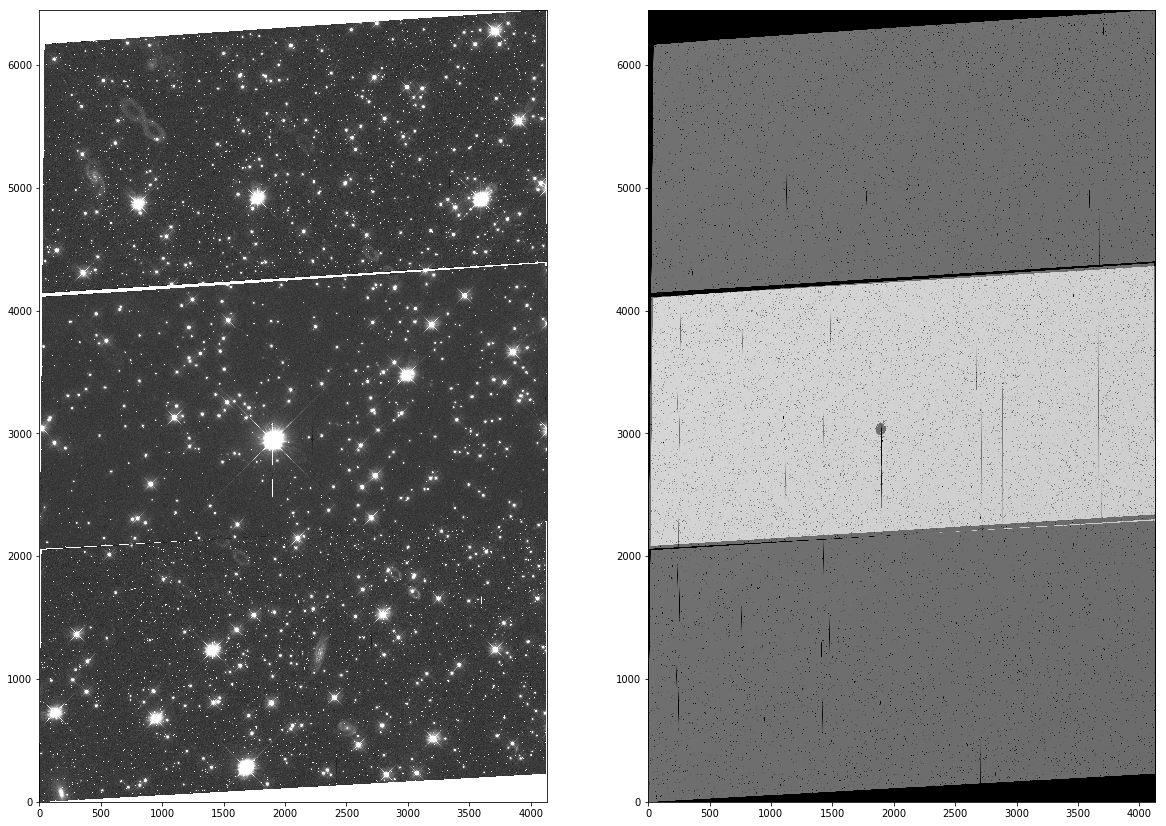

In [25]:
# Display the combined science and weight images 

sci = fits.getdata('f606w_drc_sci.fits')
wht = fits.getdata('f606w_drc_wht.fits')

fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.imshow(sci, vmin=-0.05, vmax=0.4, cmap='Greys_r', origin='lower')
ax2.imshow(wht, vmin=0, vmax=1000, cmap='Greys_r', origin='lower')

## Conclusions

Many other services have interfaces for querying catalogs which could also be used to align HST images.  In general, Gaia works very well for HST due to it's high precision, but can have a low number of sources in some regions, especially at high galactic latitudes.  Aligning images to an absolute frame provides an easy way to make data comparable across many epochs/detectors/observatories, and in many cases, makes the alignment much easier.

# About this Notebook

    Author: V. Bajaj, STScI WFC3 Team
    Updated: December 14, 2018